# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [84]:
# import libraries here; add more as necessary
import time
import logging
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# magic word for producing visualizations in notebook
%matplotlib inline

## Utils

In [2]:
def get_logger(level=logging.WARNING, force_level=False, name='logger'):
    
    logger_levels = [logging.CRITICAL, logging.ERROR, logging.WARNING,
                     logging.INFO, logging.DEBUG]
    
    if level not in logger_levels:
        raise ValueError('Invalid level name. Valid names {}'.format(logger_levels))
    
    formatter = 'UDACITY ARVATO PROJECT: %(asctime)s - %(levelname)s: %(message)s'
    date_format = '%d/%m/%Y %H:%M:%S'
    logging.basicConfig(format=formatter, datefmt=date_format, level=level)

    logger = logging.getLogger(name)
    if logger.getEffectiveLevel() == 0 or force_level:
        logger.setLevel(level)

    return logger


def set_log_level(verbose, debug):
    if verbose:
        get_logger(logging.INFO, force_level=True)
    if debug:
        get_logger(logging.DEBUG, force_level=True)


In [3]:
class Timer:
    
    def __init__(self, decimal_round=5):
        self.decimal_round = decimal_round

    def start(self):
        self.timer_start = time.perf_counter()
        self.timer_last = self.timer_start

    def lapse(self):
        last_lapse = self.timer_last
        self.timer_last = time.perf_counter()
        return round(self.timer_last - last_lapse, 5) 

    def total(self):
        return round(time.perf_counter() - self.timer_start, 5) 


In [4]:
def print_df_full(data):
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_colwidth', None)
    
    display(data)
    
    pd.set_option('display.max_rows', 10)
    pd.set_option('display.max_columns', 10)
    pd.set_option('display.max_colwidth', 50)


def convert_to_numeric(string):
    try: 
        return float(string)
    except ValueError:
        return string


## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [5]:
# load in the data
#azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
#customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

azdias = pd.read_csv(r'./datasets/azdias.csv', index_col='Unnamed: 0')
customers = pd.read_csv(r'./datasets/customers.csv', index_col='Unnamed: 0')

C:\Users\magonzac\Anaconda3\envs\pruebas\lib\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (19,20) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
logger = get_logger()
timer = Timer(decimal_round=5)

### 0.1. Check dataset integrity

#### Verify that the datasets are as shown in the above description

In [7]:
print('AZDIAS shape -', azdias.shape)
print('CUSTOMERS shape -', customers.shape)

AZDIAS shape - (891221, 366)
CUSTOMERS shape - (191652, 369)


In [8]:
demographic_columns = azdias.columns
extra_columns = [col for col in customers.columns if col not in demographic_columns]

print('Extra columns:', extra_columns)

Extra columns: ['PRODUCT_GROUP', 'CUSTOMER_GROUP', 'ONLINE_PURCHASE']


The dimensions and the extra columns, match the description.

In [9]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [10]:
customers[demographic_columns].head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,3.0,5.0,3.0,2.0,6.0,9.0,7.0,3,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,6.0,6.0,3.0,0.0,9.0,NaN,3,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,4.0,10.0,13.0,11.0,6.0,9.0,2.0,3,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,6.0,4.0,2.0,NaN,9.0,7.0,1,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,3.0,5.0,4.0,2.0,9.0,3.0,1,1,3


In [11]:
customers[extra_columns].head()

,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE
0,COSMETIC_AND_FOOD,MULTI_BUYER,0
1,FOOD,SINGLE_BUYER,0
2,COSMETIC_AND_FOOD,MULTI_BUYER,0
3,COSMETIC,MULTI_BUYER,0
4,FOOD,MULTI_BUYER,0


#### Solving WARNINGS

We can look at the datatypes of columns 18 and 19 since we got a warning while we loaded the data.

In [12]:
warning_columns = azdias.columns[[18, 19]]
print('WARNING columns:', warning_columns)

WARNING columns: Index(['CAMEO_DEUG_2015', 'CAMEO_INTL_2015'], dtype='object')


In [13]:
azdias[warning_columns].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891221 entries, 0 to 891220
Data columns (total 2 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   CAMEO_DEUG_2015  792242 non-null  object
 1   CAMEO_INTL_2015  792242 non-null  object
dtypes: object(2)
memory usage: 20.4+ MB


In [14]:
azdias['CAMEO_DEUG_2015'].unique()

array([nan, 8.0, 4.0, 2.0, 6.0, 1.0, 9.0, 5.0, 7.0, 3.0, '4', '3', '7',
       '2', '8', '9', '6', '5', '1', 'X'], dtype=object)

In [15]:
azdias['CAMEO_INTL_2015'].unique()

array([nan, 51.0, 24.0, 12.0, 43.0, 54.0, 22.0, 14.0, 13.0, 15.0, 33.0,
       41.0, 34.0, 55.0, 25.0, 23.0, 31.0, 52.0, 35.0, 45.0, 44.0, 32.0,
       '22', '24', '41', '12', '54', '51', '44', '35', '23', '25', '14',
       '34', '52', '55', '31', '32', '15', '13', '43', '33', '45', 'XX'],
      dtype=object)

We have 'X' and 'XX' as values in these columns which have not been given in the description, also there are 'nan' values.

In [16]:
def clean_warning_columns(df, columns, verbose=False, debug=False):
    set_log_level(verbose, debug)
    timer.start()
    
    logger.info('Start cleaning warning columns')
    
    logger.debug('Replacing "X", "XX" and "nan" values with -1')
    replacements = {"X": np.nan, "XX": np.nan}
    df[columns] = df[columns].replace(replacements)
    logger.debug('Replaced columns: {0} in {1} seconds'.format(list(columns), timer.lapse()))
    
    logger.debug('Changing data type to float')
    df[columns] = df[columns].astype(float)
    logger.debug('Changed data type to float in {} seconds'.format(timer.lapse()))
    
    logger.info('End cleaning warning columns in {} seconds'.format(timer.total()))
    return df

In [17]:
azdias = clean_warning_columns(azdias, warning_columns, verbose=True, debug=True)

UDACITY ARVATO PROJECT: 06/05/2021 22:53:44 - INFO: Start cleaning warning columns
UDACITY ARVATO PROJECT: 06/05/2021 22:53:44 - DEBUG: Replacing "X", "XX" and "nan" values with -1
UDACITY ARVATO PROJECT: 06/05/2021 22:53:44 - DEBUG: Replaced columns: ['CAMEO_DEUG_2015', 'CAMEO_INTL_2015'] in 0.36622 seconds
UDACITY ARVATO PROJECT: 06/05/2021 22:53:44 - DEBUG: Changing data type to float
UDACITY ARVATO PROJECT: 06/05/2021 22:53:44 - DEBUG: Changed data type to float in 0.22814 seconds
UDACITY ARVATO PROJECT: 06/05/2021 22:53:45 - INFO: End cleaning warning columns in 0.59524 seconds


In [18]:
customers = clean_warning_columns(customers, warning_columns, verbose=True, debug=True)

UDACITY ARVATO PROJECT: 06/05/2021 22:53:45 - INFO: Start cleaning warning columns
UDACITY ARVATO PROJECT: 06/05/2021 22:53:45 - DEBUG: Replacing "X", "XX" and "nan" values with -1
UDACITY ARVATO PROJECT: 06/05/2021 22:53:45 - DEBUG: Replaced columns: ['CAMEO_DEUG_2015', 'CAMEO_INTL_2015'] in 0.08912 seconds
UDACITY ARVATO PROJECT: 06/05/2021 22:53:45 - DEBUG: Changing data type to float
UDACITY ARVATO PROJECT: 06/05/2021 22:53:45 - DEBUG: Changed data type to float in 0.05954 seconds
UDACITY ARVATO PROJECT: 06/05/2021 22:53:45 - INFO: End cleaning warning columns in 0.14939 seconds


Check whether the replacement has been carried out properly.

In [19]:
azdias['CAMEO_DEUG_2015'].unique()

array([nan,  8.,  4.,  2.,  6.,  1.,  9.,  5.,  7.,  3.])

In [20]:
azdias['CAMEO_INTL_2015'].unique()

array([nan, 51., 24., 12., 43., 54., 22., 14., 13., 15., 33., 41., 34.,
       55., 25., 23., 31., 52., 35., 45., 44., 32.])

### 0.2. Explore metadata datasets

Additionally we have been given two excel books.

- DIAS Attributes - Values 2017.xlsx - Has a description of demographic columns, information about range of values each column can take and their respective meanings.Loaded in metadata_values.
- DIAS Information Levels - Attributes 2017.xlsx - Has detailed information about each column with additional notes wherever required. Loaded in metadata_info_levels.

We can use these two dataframes to understand the data.

In [21]:
metadata_values = pd.read_csv(r'./datasets/metadata/metadata_values.txt', sep='\t', encoding='UTF-16')
metadata_info_levels = pd.read_csv(r'./datasets/metadata/metadata_info_levels.txt', sep='\t', encoding='UTF-16')

In [22]:
metadata_values.head(10)

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,NaN,NaN,0,no classification possible
2,NaN,NaN,1,passive elderly
3,NaN,NaN,2,cultural elderly
4,NaN,NaN,3,experience-driven elderly
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
6,NaN,NaN,1,< 30 years
7,NaN,NaN,2,30 - 45 years
8,NaN,NaN,3,46 - 60 years
9,NaN,NaN,4,> 60 years


In [23]:
metadata_info_levels.head(10)

,Information level,Attribute,Description,Additional notes
0,NaN,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the informatio...
1,Person,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-referen...
2,NaN,ANREDE_KZ,gender,NaN
3,NaN,CJT_GESAMTTYP,Customer-Journey-Typology relating to the pref...,"relating to the preferred information, marketi..."
4,NaN,FINANZ_MINIMALIST,financial typology: low financial interest,Gfk-Typology based on a representative househo...
5,NaN,FINANZ_SPARER,financial typology: money saver,NaN
6,NaN,FINANZ_VORSORGER,financial typology: be prepared,NaN
7,NaN,FINANZ_ANLEGER,financial typology: investor,NaN
8,NaN,FINANZ_UNAUFFAELLIGER,financial typology: unremarkable,NaN
9,NaN,FINANZ_HAUSBAUER,financial typology: main focus is the own house,NaN


##### Metadata datasets preprocessing

We can use the ffill() method of pandas, to replace the NaN values of the dataset by the value of the previous row.

In [24]:
metadata_values[['Attribute', 'Description']] = metadata_values[['Attribute', 'Description']].ffill()

In [25]:
metadata_values.head(10)

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,best-ager typology,0,no classification possible
2,AGER_TYP,best-ager typology,1,passive elderly
3,AGER_TYP,best-ager typology,2,cultural elderly
4,AGER_TYP,best-ager typology,3,experience-driven elderly
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
6,ALTERSKATEGORIE_GROB,age classification through prename analysis,1,< 30 years
7,ALTERSKATEGORIE_GROB,age classification through prename analysis,2,30 - 45 years
8,ALTERSKATEGORIE_GROB,age classification through prename analysis,3,46 - 60 years
9,ALTERSKATEGORIE_GROB,age classification through prename analysis,4,> 60 years


##### Described features

We must check how many features are described in the metadata datasets.

In [26]:
metadata_info_levels.drop_duplicates(subset=['Attribute'])

,Information level,Attribute,Description,Additional notes
0,NaN,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the informatio...
1,Person,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-referen...
2,NaN,ANREDE_KZ,gender,NaN
3,NaN,CJT_GESAMTTYP,Customer-Journey-Typology relating to the pref...,"relating to the preferred information, marketi..."
4,NaN,FINANZ_MINIMALIST,financial typology: low financial interest,Gfk-Typology based on a representative househo...
...,...,...,...,...
308,Community,ARBEIT,share of unemployed person in the community,NaN
309,NaN,EINWOHNER,inhabitants,NaN
310,NaN,GKZ,standardized community-code,NaN
311,NaN,ORTSGR_KLS9,classified number of inhabitants,NaN


In [27]:
metadata_values.drop_duplicates(subset=['Attribute'])

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
11,ALTER_HH,main age within the household,0,unknown / no main age detectable
33,ANREDE_KZ,gender,"-1, 0",unknown
36,ANZ_HAUSHALTE_AKTIV,number of households in the building,…,numeric value (typically coded from 1-10)
...,...,...,...,...
2219,WOHNDAUER_2008,length of residence,"-1, 0",unknown
2229,WOHNLAGE,residential-area,-1,unknown
2238,WACHSTUMSGEBIET_NB,growing area (population growth in the last 5 ...,"-1, 0",unknown
2244,W_KEIT_KIND_HH,likelihood of a child present in this household,"-1, 0",unknown


We can see that there are only 313 (in metadata_info_levels dataset) and 314 (in metadata_values dataset) different columns described, but in the AZDIAS dataset, there are 366 demographic columns. We need to check which features have no description in metadata datasets.

In [28]:
metadata_columns = metadata_values.Attribute.unique().tolist()

described_columns = (set(metadata_columns) & set(demographic_columns))
undescribed_columns = (set(metadata_columns) - set(demographic_columns))

print("Number of described demographic columns: ", len(described_columns))
print("Number of undescribed demographic columns: ", len(undescribed_columns))

Number of described demographic columns:  272
Number of undescribed demographic columns:  42


In [29]:
print_df_full(metadata_values[['Attribute', 'Description']].drop_duplicates(subset=['Attribute']))

,Attribute,Description
0,AGER_TYP,best-ager typology
5,ALTERSKATEGORIE_GROB,age classification through prename analysis
11,ALTER_HH,main age within the household
33,ANREDE_KZ,gender
36,ANZ_HAUSHALTE_AKTIV,number of households in the building
37,ANZ_HH_TITEL,number of academic title holder in building
38,ANZ_PERSONEN,number of adult persons in the household
39,ANZ_TITEL,number of professional title holder in household
40,BALLRAUM,distance to next urban centre
48,BIP_FLAG,business-flag indicating companies in the building


### 0.3. Data Preprocessing

##### Nulls normalization

In [30]:
metadata_values.head(10)

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,best-ager typology,0,no classification possible
2,AGER_TYP,best-ager typology,1,passive elderly
3,AGER_TYP,best-ager typology,2,cultural elderly
4,AGER_TYP,best-ager typology,3,experience-driven elderly
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
6,ALTERSKATEGORIE_GROB,age classification through prename analysis,1,< 30 years
7,ALTERSKATEGORIE_GROB,age classification through prename analysis,2,30 - 45 years
8,ALTERSKATEGORIE_GROB,age classification through prename analysis,3,46 - 60 years
9,ALTERSKATEGORIE_GROB,age classification through prename analysis,4,> 60 years


Looking at the metadata of the columns in the provided excel workbooks, it can be seen that some columns have their own category to indicate a null value (for example categories like 'unknown', 'unknown / no main age detectable', 'numeric value', etc..). We could to unify the null values and replace these categories with np.nan values. Will only be done for the 272 columns that are described in the metadata datasets, as for the remaining 42 columns, we do not know the meaning of the values.

In [31]:
def get_unkown_values_data(metadata, unkown_categories, verbose=False, debug=False):
    set_log_level(verbose, debug)
    timer.start()
    
    logger.info('Start getting unkown categories from metadata')
    
    unknown_values = metadata[metadata['Meaning'].isin(unkown_categories)]
    unknown_values = unknown_values.reset_index(drop=True)
    logger.debug('Number of features with unknown categories:'.format(len(unknown_values)))
    
    logger.info('End getting unkown categories from metadata in {} seconds'.format(timer.total()))
    return unknown_values


In [32]:
unknown_values = ['unknown', 'unknown / no main age detectable', 'numeric value', 'none']

unknown_data = get_unkown_values_data(metadata_values, unknown_values, verbose=True, debug=True)
print_df_full(unknown_data)

UDACITY ARVATO PROJECT: 06/05/2021 22:53:45 - INFO: Start getting unkown categories from metadata
UDACITY ARVATO PROJECT: 06/05/2021 22:53:45 - DEBUG: Number of features with unknown categories:
UDACITY ARVATO PROJECT: 06/05/2021 22:53:45 - INFO: End getting unkown categories from metadata in 0.00482 seconds


,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
2,ALTER_HH,main age within the household,0,unknown / no main age detectable
3,ANREDE_KZ,gender,"-1, 0",unknown
4,BALLRAUM,distance to next urban centre,-1,unknown
5,BIP_FLAG,business-flag indicating companies in the building,-1,unknown
6,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,-1,unknown
7,CAMEO_DEUINTL_2015,CAMEO classification 2015 - international typology,-1,unknown
8,CJT_GESAMTTYP,customer journey typology,0,unknown
9,D19_KK_KUNDENTYP,consumption movement in the last 12 months,-1,unknown


In [33]:
def replace_unknown_values(data, metadata, unknown_values, verbose=False, debug=False):
    set_log_level(verbose, debug)
    timer.start()
    
    unknown_data = get_unkown_values_data(metadata, unknown_values, verbose=verbose, debug=debug)
    
    logger.info('Start replacing unkown values')
    
    for attribute in unknown_data['Attribute']:
        
        if attribute in data.columns:
            unknown_categories = _get_categories(unknown_data, attribute)
            data[attribute] = data[attribute].apply(lambda x: np.nan if x in unknown_categories[attribute] else x)
            
            logger.debug('Replaced {0} to NaN in {1} column in {2} seconds'.format(
                unknown_categories[attribute], attribute, timer.lapse()))
        else:
            logger.debug('Attribute {} not in data'.format(attribute))
    
    logger.info('End replacing unkown values in {} seconds'.format(timer.total()))
    return data


def _get_categories(data, attribute):
    output = {}
    for attribute in data['Attribute']:
        categories = data[data['Attribute'] == attribute]['Value']
        categories = categories.astype(str).str.cat(sep=', ')
        categories = [str(x).strip() for x in categories.split(', ')]

        output[attribute] = [convert_to_numeric(x) for x in categories]
    return output


In [34]:
azdias = replace_unknown_values(azdias, metadata_values, unknown_values, verbose=True, debug=True)

UDACITY ARVATO PROJECT: 06/05/2021 22:53:45 - INFO: Start getting unkown categories from metadata
UDACITY ARVATO PROJECT: 06/05/2021 22:53:45 - DEBUG: Number of features with unknown categories:
UDACITY ARVATO PROJECT: 06/05/2021 22:53:45 - INFO: End getting unkown categories from metadata in 0.00255 seconds
UDACITY ARVATO PROJECT: 06/05/2021 22:53:45 - INFO: Start replacing unkown values
UDACITY ARVATO PROJECT: 06/05/2021 22:53:46 - DEBUG: Replaced [-1.0] to NaN in AGER_TYP column in 0.91858 seconds
UDACITY ARVATO PROJECT: 06/05/2021 22:53:47 - DEBUG: Replaced [-1.0, 0.0] to NaN in ALTERSKATEGORIE_GROB column in 0.6774 seconds
UDACITY ARVATO PROJECT: 06/05/2021 22:53:49 - DEBUG: Replaced [0.0] to NaN in ALTER_HH column in 2.00974 seconds
UDACITY ARVATO PROJECT: 06/05/2021 22:53:49 - DEBUG: Replaced [-1.0, 0.0] to NaN in ANREDE_KZ column in 0.53602 seconds
UDACITY ARVATO PROJECT: 06/05/2021 22:53:50 - DEBUG: Replaced [-1.0] to NaN in BALLRAUM column in 0.46434 seconds
UDACITY ARVATO PR

UDACITY ARVATO PROJECT: 06/05/2021 22:54:21 - DEBUG: Replaced [-1.0, 9.0] to NaN in KBA05_KRSVAN column in 0.48074 seconds
UDACITY ARVATO PROJECT: 06/05/2021 22:54:21 - DEBUG: Replaced [-1.0, 9.0] to NaN in KBA05_KRSZUL column in 0.49379 seconds
UDACITY ARVATO PROJECT: 06/05/2021 22:54:22 - DEBUG: Replaced [-1.0, 9.0] to NaN in KBA05_KW1 column in 0.47682 seconds
UDACITY ARVATO PROJECT: 06/05/2021 22:54:22 - DEBUG: Replaced [-1.0, 9.0] to NaN in KBA05_KW2 column in 0.47089 seconds
UDACITY ARVATO PROJECT: 06/05/2021 22:54:23 - DEBUG: Replaced [-1.0, 9.0, 0.0] to NaN in KBA05_KW3 column in 0.51437 seconds
UDACITY ARVATO PROJECT: 06/05/2021 22:54:23 - DEBUG: Replaced [-1.0, 9.0, 0.0] to NaN in KBA05_KW3 column in 0.44515 seconds
UDACITY ARVATO PROJECT: 06/05/2021 22:54:24 - DEBUG: Replaced [-1.0, 9.0] to NaN in KBA05_MAXAH column in 0.47715 seconds
UDACITY ARVATO PROJECT: 06/05/2021 22:54:24 - DEBUG: Replaced [-1.0, 9.0] to NaN in KBA05_MAXBJ column in 0.47483 seconds
UDACITY ARVATO PROJE

UDACITY ARVATO PROJECT: 06/05/2021 22:54:52 - DEBUG: Replaced [-1.0, 0.0] to NaN in KBA13_BJ_2000 column in 0.43033 seconds
UDACITY ARVATO PROJECT: 06/05/2021 22:54:53 - DEBUG: Replaced [-1.0, 0.0] to NaN in KBA13_BJ_2004 column in 0.50774 seconds
UDACITY ARVATO PROJECT: 06/05/2021 22:54:53 - DEBUG: Replaced [-1.0, 0.0] to NaN in KBA13_BJ_2004 column in 0.46365 seconds
UDACITY ARVATO PROJECT: 06/05/2021 22:54:54 - DEBUG: Replaced [-1.0, 0.0] to NaN in KBA13_BJ_2006 column in 0.48191 seconds
UDACITY ARVATO PROJECT: 06/05/2021 22:54:54 - DEBUG: Replaced [-1.0, 0.0] to NaN in KBA13_BJ_2006 column in 0.42992 seconds
UDACITY ARVATO PROJECT: 06/05/2021 22:54:55 - DEBUG: Replaced [-1.0, 0.0] to NaN in KBA13_BJ_2008 column in 0.49377 seconds
UDACITY ARVATO PROJECT: 06/05/2021 22:54:55 - DEBUG: Replaced [-1.0, 0.0] to NaN in KBA13_BJ_2008 column in 0.43184 seconds
UDACITY ARVATO PROJECT: 06/05/2021 22:54:55 - DEBUG: Replaced [-1.0, 0.0] to NaN in KBA13_BJ_2009 column in 0.48717 seconds
UDACITY 

UDACITY ARVATO PROJECT: 06/05/2021 22:55:22 - DEBUG: Replaced [-1.0, 0.0] to NaN in KBA13_HERST_ASIEN column in 0.44278 seconds
UDACITY ARVATO PROJECT: 06/05/2021 22:55:22 - DEBUG: Replaced [-1.0, 0.0] to NaN in KBA13_HERST_ASIEN column in 0.40934 seconds
UDACITY ARVATO PROJECT: 06/05/2021 22:55:23 - DEBUG: Replaced [-1.0, 0.0] to NaN in KBA13_HERST_AUDI_VW column in 0.44121 seconds
UDACITY ARVATO PROJECT: 06/05/2021 22:55:23 - DEBUG: Replaced [-1.0, 0.0] to NaN in KBA13_HERST_AUDI_VW column in 0.42074 seconds
UDACITY ARVATO PROJECT: 06/05/2021 22:55:24 - DEBUG: Replaced [-1.0, 0.0] to NaN in KBA13_HERST_BMW_BENZ column in 0.42591 seconds
UDACITY ARVATO PROJECT: 06/05/2021 22:55:24 - DEBUG: Replaced [-1.0, 0.0] to NaN in KBA13_HERST_BMW_BENZ column in 0.41785 seconds
UDACITY ARVATO PROJECT: 06/05/2021 22:55:25 - DEBUG: Replaced [-1.0, 0.0] to NaN in KBA13_HERST_EUROPA column in 0.42336 seconds
UDACITY ARVATO PROJECT: 06/05/2021 22:55:25 - DEBUG: Replaced [-1.0, 0.0] to NaN in KBA13_HER

UDACITY ARVATO PROJECT: 06/05/2021 22:55:51 - DEBUG: Replaced [-1.0, 0.0] to NaN in KBA13_KW_120 column in 0.47681 seconds
UDACITY ARVATO PROJECT: 06/05/2021 22:55:51 - DEBUG: Replaced [-1.0, 0.0] to NaN in KBA13_KW_121 column in 0.52287 seconds
UDACITY ARVATO PROJECT: 06/05/2021 22:55:52 - DEBUG: Replaced [-1.0, 0.0] to NaN in KBA13_KW_121 column in 0.51749 seconds
UDACITY ARVATO PROJECT: 06/05/2021 22:55:52 - DEBUG: Replaced [-1.0, 0.0] to NaN in KBA13_MAZDA column in 0.47812 seconds
UDACITY ARVATO PROJECT: 06/05/2021 22:55:53 - DEBUG: Replaced [-1.0, 0.0] to NaN in KBA13_MAZDA column in 0.45435 seconds
UDACITY ARVATO PROJECT: 06/05/2021 22:55:53 - DEBUG: Replaced [-1.0, 0.0] to NaN in KBA13_MERCEDES column in 0.44221 seconds
UDACITY ARVATO PROJECT: 06/05/2021 22:55:54 - DEBUG: Replaced [-1.0, 0.0] to NaN in KBA13_MERCEDES column in 0.41735 seconds
UDACITY ARVATO PROJECT: 06/05/2021 22:55:54 - DEBUG: Replaced [-1.0, 0.0] to NaN in KBA13_MOTOR column in 0.44748 seconds
UDACITY ARVATO 

UDACITY ARVATO PROJECT: 06/05/2021 22:56:20 - DEBUG: Replaced [-1.0, 0.0] to NaN in KBA13_VW column in 0.56053 seconds
UDACITY ARVATO PROJECT: 06/05/2021 22:56:20 - DEBUG: Replaced [-1.0, 0.0] to NaN in KBA13_VW column in 0.50323 seconds
UDACITY ARVATO PROJECT: 06/05/2021 22:56:21 - DEBUG: Replaced [-1.0, 0.0] to NaN in KKK column in 0.48659 seconds
UDACITY ARVATO PROJECT: 06/05/2021 22:56:21 - DEBUG: Replaced ['…'] to NaN in MIN_GEBAEUDEJAHR column in 0.42232 seconds
UDACITY ARVATO PROJECT: 06/05/2021 22:56:22 - DEBUG: Replaced [6.0] to NaN in MOBI_REGIO column in 0.41944 seconds
UDACITY ARVATO PROJECT: 06/05/2021 22:56:23 - DEBUG: Replaced [-1.0, 0.0] to NaN in NATIONALITAET_KZ column in 1.55588 seconds
UDACITY ARVATO PROJECT: 06/05/2021 22:56:24 - DEBUG: Replaced [0.0] to NaN in ONLINE_AFFINITAET column in 0.6862 seconds
UDACITY ARVATO PROJECT: 06/05/2021 22:56:24 - DEBUG: Replaced [-1.0] to NaN in ORTSGR_KLS9 column in 0.57635 seconds
UDACITY ARVATO PROJECT: 06/05/2021 22:56:25 - D

In [35]:
customers = replace_unknown_values(customers, metadata_values, unknown_values, verbose=True, debug=True)

UDACITY ARVATO PROJECT: 06/05/2021 22:56:44 - INFO: Start getting unkown categories from metadata
UDACITY ARVATO PROJECT: 06/05/2021 22:56:44 - DEBUG: Number of features with unknown categories:
UDACITY ARVATO PROJECT: 06/05/2021 22:56:44 - INFO: End getting unkown categories from metadata in 0.00967 seconds
UDACITY ARVATO PROJECT: 06/05/2021 22:56:44 - INFO: Start replacing unkown values
UDACITY ARVATO PROJECT: 06/05/2021 22:56:44 - DEBUG: Replaced [-1.0] to NaN in AGER_TYP column in 0.44787 seconds
UDACITY ARVATO PROJECT: 06/05/2021 22:56:45 - DEBUG: Replaced [-1.0, 0.0] to NaN in ALTERSKATEGORIE_GROB column in 0.28599 seconds
UDACITY ARVATO PROJECT: 06/05/2021 22:56:45 - DEBUG: Replaced [0.0] to NaN in ALTER_HH column in 0.27272 seconds
UDACITY ARVATO PROJECT: 06/05/2021 22:56:45 - DEBUG: Replaced [-1.0, 0.0] to NaN in ANREDE_KZ column in 0.308 seconds
UDACITY ARVATO PROJECT: 06/05/2021 22:56:45 - DEBUG: Replaced [-1.0] to NaN in BALLRAUM column in 0.24917 seconds
UDACITY ARVATO PRO

UDACITY ARVATO PROJECT: 06/05/2021 22:57:00 - DEBUG: Replaced [-1.0, 9.0] to NaN in KBA05_KRSVAN column in 0.26738 seconds
UDACITY ARVATO PROJECT: 06/05/2021 22:57:01 - DEBUG: Replaced [-1.0, 9.0] to NaN in KBA05_KRSZUL column in 0.25714 seconds
UDACITY ARVATO PROJECT: 06/05/2021 22:57:01 - DEBUG: Replaced [-1.0, 9.0] to NaN in KBA05_KW1 column in 0.25766 seconds
UDACITY ARVATO PROJECT: 06/05/2021 22:57:01 - DEBUG: Replaced [-1.0, 9.0] to NaN in KBA05_KW2 column in 0.24892 seconds
UDACITY ARVATO PROJECT: 06/05/2021 22:57:01 - DEBUG: Replaced [-1.0, 9.0, 0.0] to NaN in KBA05_KW3 column in 0.25159 seconds
UDACITY ARVATO PROJECT: 06/05/2021 22:57:02 - DEBUG: Replaced [-1.0, 9.0, 0.0] to NaN in KBA05_KW3 column in 0.25226 seconds
UDACITY ARVATO PROJECT: 06/05/2021 22:57:02 - DEBUG: Replaced [-1.0, 9.0] to NaN in KBA05_MAXAH column in 0.26079 seconds
UDACITY ARVATO PROJECT: 06/05/2021 22:57:02 - DEBUG: Replaced [-1.0, 9.0] to NaN in KBA05_MAXBJ column in 0.25901 seconds
UDACITY ARVATO PROJE

UDACITY ARVATO PROJECT: 06/05/2021 22:57:17 - DEBUG: Replaced [-1.0, 0.0] to NaN in KBA13_BJ_2000 column in 0.2933 seconds
UDACITY ARVATO PROJECT: 06/05/2021 22:57:18 - DEBUG: Replaced [-1.0, 0.0] to NaN in KBA13_BJ_2004 column in 0.25396 seconds
UDACITY ARVATO PROJECT: 06/05/2021 22:57:18 - DEBUG: Replaced [-1.0, 0.0] to NaN in KBA13_BJ_2004 column in 0.25185 seconds
UDACITY ARVATO PROJECT: 06/05/2021 22:57:18 - DEBUG: Replaced [-1.0, 0.0] to NaN in KBA13_BJ_2006 column in 0.25346 seconds
UDACITY ARVATO PROJECT: 06/05/2021 22:57:18 - DEBUG: Replaced [-1.0, 0.0] to NaN in KBA13_BJ_2006 column in 0.25064 seconds
UDACITY ARVATO PROJECT: 06/05/2021 22:57:19 - DEBUG: Replaced [-1.0, 0.0] to NaN in KBA13_BJ_2008 column in 0.25072 seconds
UDACITY ARVATO PROJECT: 06/05/2021 22:57:19 - DEBUG: Replaced [-1.0, 0.0] to NaN in KBA13_BJ_2008 column in 0.25779 seconds
UDACITY ARVATO PROJECT: 06/05/2021 22:57:19 - DEBUG: Replaced [-1.0, 0.0] to NaN in KBA13_BJ_2009 column in 0.2556 seconds
UDACITY AR

UDACITY ARVATO PROJECT: 06/05/2021 22:57:34 - DEBUG: Replaced [-1.0, 0.0] to NaN in KBA13_HERST_ASIEN column in 0.24788 seconds
UDACITY ARVATO PROJECT: 06/05/2021 22:57:34 - DEBUG: Replaced [-1.0, 0.0] to NaN in KBA13_HERST_ASIEN column in 0.26132 seconds
UDACITY ARVATO PROJECT: 06/05/2021 22:57:34 - DEBUG: Replaced [-1.0, 0.0] to NaN in KBA13_HERST_AUDI_VW column in 0.255 seconds
UDACITY ARVATO PROJECT: 06/05/2021 22:57:35 - DEBUG: Replaced [-1.0, 0.0] to NaN in KBA13_HERST_AUDI_VW column in 0.2497 seconds
UDACITY ARVATO PROJECT: 06/05/2021 22:57:35 - DEBUG: Replaced [-1.0, 0.0] to NaN in KBA13_HERST_BMW_BENZ column in 0.25083 seconds
UDACITY ARVATO PROJECT: 06/05/2021 22:57:35 - DEBUG: Replaced [-1.0, 0.0] to NaN in KBA13_HERST_BMW_BENZ column in 0.25189 seconds
UDACITY ARVATO PROJECT: 06/05/2021 22:57:35 - DEBUG: Replaced [-1.0, 0.0] to NaN in KBA13_HERST_EUROPA column in 0.25598 seconds
UDACITY ARVATO PROJECT: 06/05/2021 22:57:36 - DEBUG: Replaced [-1.0, 0.0] to NaN in KBA13_HERST_

UDACITY ARVATO PROJECT: 06/05/2021 22:57:50 - DEBUG: Replaced [-1.0, 0.0] to NaN in KBA13_KW_120 column in 0.24951 seconds
UDACITY ARVATO PROJECT: 06/05/2021 22:57:50 - DEBUG: Replaced [-1.0, 0.0] to NaN in KBA13_KW_121 column in 0.25579 seconds
UDACITY ARVATO PROJECT: 06/05/2021 22:57:51 - DEBUG: Replaced [-1.0, 0.0] to NaN in KBA13_KW_121 column in 0.255 seconds
UDACITY ARVATO PROJECT: 06/05/2021 22:57:51 - DEBUG: Replaced [-1.0, 0.0] to NaN in KBA13_MAZDA column in 0.26346 seconds
UDACITY ARVATO PROJECT: 06/05/2021 22:57:51 - DEBUG: Replaced [-1.0, 0.0] to NaN in KBA13_MAZDA column in 0.25641 seconds
UDACITY ARVATO PROJECT: 06/05/2021 22:57:52 - DEBUG: Replaced [-1.0, 0.0] to NaN in KBA13_MERCEDES column in 0.27316 seconds
UDACITY ARVATO PROJECT: 06/05/2021 22:57:52 - DEBUG: Replaced [-1.0, 0.0] to NaN in KBA13_MERCEDES column in 0.27668 seconds
UDACITY ARVATO PROJECT: 06/05/2021 22:57:52 - DEBUG: Replaced [-1.0, 0.0] to NaN in KBA13_MOTOR column in 0.27279 seconds
UDACITY ARVATO PR

UDACITY ARVATO PROJECT: 06/05/2021 22:58:07 - DEBUG: Replaced [-1.0, 0.0] to NaN in KBA13_VW column in 0.25776 seconds
UDACITY ARVATO PROJECT: 06/05/2021 22:58:07 - DEBUG: Replaced [-1.0, 0.0] to NaN in KBA13_VW column in 0.2648 seconds
UDACITY ARVATO PROJECT: 06/05/2021 22:58:08 - DEBUG: Replaced [-1.0, 0.0] to NaN in KKK column in 0.25465 seconds
UDACITY ARVATO PROJECT: 06/05/2021 22:58:08 - DEBUG: Replaced ['…'] to NaN in MIN_GEBAEUDEJAHR column in 0.25358 seconds
UDACITY ARVATO PROJECT: 06/05/2021 22:58:08 - DEBUG: Replaced [6.0] to NaN in MOBI_REGIO column in 0.25208 seconds
UDACITY ARVATO PROJECT: 06/05/2021 22:58:08 - DEBUG: Replaced [-1.0, 0.0] to NaN in NATIONALITAET_KZ column in 0.3591 seconds
UDACITY ARVATO PROJECT: 06/05/2021 22:58:09 - DEBUG: Replaced [0.0] to NaN in ONLINE_AFFINITAET column in 0.24594 seconds
UDACITY ARVATO PROJECT: 06/05/2021 22:58:09 - DEBUG: Replaced [-1.0] to NaN in ORTSGR_KLS9 column in 0.24554 seconds
UDACITY ARVATO PROJECT: 06/05/2021 22:58:09 - DE

### 0.4. Data Univariate Analysis

#### Remove columns with a high percentage of Null values

In [36]:
def get_missing_columns(data, threshold=0.3, verbose=False, debug=False):
    set_log_level(verbose, debug)
    timer.start()
    
    logger.info('Start labelling columns as missing')
    
    data_missing_pctg = _get_missing_percentage_column(data)
    remove_columns = data_missing_pctg['column'][data_missing_pctg['missing_pctg'] > threshold].tolist()
    logger.debug('Columns labelled as missing: {}'.format(remove_columns))
        
    logger.info('End labelling columns as missing in {}'.format(timer.total()))
    return remove_columns
    

def _get_missing_percentage_column(data):
    missing_pctg = data.isna().sum() / len(data)
    
    return pd.DataFrame({'column': data.columns,
                         'missing_pctg': missing_pctg}
                       ).reset_index(drop=True)


In [37]:
# missing columns in AZDIAS
missing_columns_azdias = get_missing_columns(azdias, verbose=True, debug=True)

UDACITY ARVATO PROJECT: 06/05/2021 22:58:19 - INFO: Start labelling columns as missing
UDACITY ARVATO PROJECT: 06/05/2021 22:58:26 - DEBUG: Columns labelled as missing: ['AGER_TYP', 'ALTER_HH', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'EXTSEL992', 'KBA05_ANHANG', 'KBA05_BAUMAX', 'KBA05_CCM4', 'KBA05_KW3', 'KBA05_MOD1', 'KBA05_MOD8', 'KBA05_MOTRAD', 'KBA05_SEG1', 'KBA05_SEG5', 'KBA05_SEG6', 'KBA05_SEG7', 'KBA05_SEG8', 'KBA05_SEG9', 'KK_KUNDENTYP', 'PLZ8_ANTG4', 'TITEL_KZ']
UDACITY ARVATO PROJECT: 06/05/2021 22:58:26 - INFO: End labelling columns as missing in 7.05485


In [38]:
# missing columns in CUSTOMERS
missing_columns_customers = get_missing_columns(customers, verbose=True, debug=True)

UDACITY ARVATO PROJECT: 06/05/2021 22:58:26 - INFO: Start labelling columns as missing
UDACITY ARVATO PROJECT: 06/05/2021 22:59:11 - DEBUG: Columns labelled as missing: ['AGER_TYP', 'ALTER_HH', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'EXTSEL992', 'KBA05_ALTER1', 'KBA05_ALTER4', 'KBA05_ANHANG', 'KBA05_BAUMAX', 'KBA05_CCM4', 'KBA05_DIESEL', 'KBA05_HERST1', 'KBA05_HERST3', 'KBA05_HERST4', 'KBA05_HERST5', 'KBA05_KW3', 'KBA05_MOD1', 'KBA05_MOD4', 'KBA05_MOD8', 'KBA05_MOTRAD', 'KBA05_SEG1', 'KBA05_SEG10', 'KBA05_SEG5', 'KBA05_SEG6', 'KBA05_SEG7', 'KBA05_SEG8', 'KBA05_SEG9', 'KBA05_VORB2', 'KBA05_ZUL3', 'KBA05_ZUL4', 'KBA13_BJ_2008', 'KBA13_BJ_2009', 'KBA13_CCM_0_1400', 'KBA13_CCM_1000', 'KBA13_CCM_1200', 'KBA13_CCM_1800', 'KBA13_CCM_2500', 'KBA13_CCM_2501', 'KBA13_CCM_3000', 'KBA13_KMH_0_140', 'KBA13_KMH_211', 'KBA13_KMH_250', 'KBA13_KW_110', 'KBA13_KW_120', 'KBA13_KW_121', 'KBA13_KW_40', 'KBA13_KW_50', 'KBA13_KW_60', 'KBA13_KW_70', 'KBA13_KW_80', 'KBA13_KW_90', 'KBA13_SE

In [39]:
missing_columns = list(set(missing_columns_azdias) & set(missing_columns_customers))
missing_columns

['KBA05_SEG1',
 'KBA05_CCM4',
 'KBA05_MOD1',
 'EXTSEL992',
 'TITEL_KZ',
 'KBA05_KW3',
 'AGER_TYP',
 'KBA05_MOTRAD',
 'ALTER_KIND3',
 'KBA05_SEG6',
 'KBA05_SEG8',
 'ALTER_HH',
 'KBA05_SEG7',
 'ALTER_KIND1',
 'PLZ8_ANTG4',
 'KK_KUNDENTYP',
 'KBA05_SEG9',
 'KBA05_SEG5',
 'ALTER_KIND4',
 'KBA05_BAUMAX',
 'KBA05_MOD8',
 'ALTER_KIND2',
 'KBA05_ANHANG']

In [40]:
def drop_columns(data, column_list, verbose=False, debug=False):
    set_log_level(verbose, debug)
    timer.start()
    
    logger.info('Start removing columns')
    
    data = data.drop(column_list, axis=1)
    logger.debug('Removed columns: {}'.format(column_list))
    
    logger.info('End removing columns in {} seconds'.format(timer.total()))
    return data


In [41]:
azdias = drop_columns(azdias, missing_columns, verbose=True, debug=True)

UDACITY ARVATO PROJECT: 06/05/2021 22:59:11 - INFO: Start removing columns
UDACITY ARVATO PROJECT: 06/05/2021 22:59:24 - DEBUG: Removed columns: ['KBA05_SEG1', 'KBA05_CCM4', 'KBA05_MOD1', 'EXTSEL992', 'TITEL_KZ', 'KBA05_KW3', 'AGER_TYP', 'KBA05_MOTRAD', 'ALTER_KIND3', 'KBA05_SEG6', 'KBA05_SEG8', 'ALTER_HH', 'KBA05_SEG7', 'ALTER_KIND1', 'PLZ8_ANTG4', 'KK_KUNDENTYP', 'KBA05_SEG9', 'KBA05_SEG5', 'ALTER_KIND4', 'KBA05_BAUMAX', 'KBA05_MOD8', 'ALTER_KIND2', 'KBA05_ANHANG']
UDACITY ARVATO PROJECT: 06/05/2021 22:59:24 - INFO: End removing columns in 13.59706 seconds


In [42]:
customers = drop_columns(customers, missing_columns, verbose=True, debug=True)

UDACITY ARVATO PROJECT: 06/05/2021 22:59:25 - INFO: Start removing columns
UDACITY ARVATO PROJECT: 06/05/2021 23:00:13 - DEBUG: Removed columns: ['KBA05_SEG1', 'KBA05_CCM4', 'KBA05_MOD1', 'EXTSEL992', 'TITEL_KZ', 'KBA05_KW3', 'AGER_TYP', 'KBA05_MOTRAD', 'ALTER_KIND3', 'KBA05_SEG6', 'KBA05_SEG8', 'ALTER_HH', 'KBA05_SEG7', 'ALTER_KIND1', 'PLZ8_ANTG4', 'KK_KUNDENTYP', 'KBA05_SEG9', 'KBA05_SEG5', 'ALTER_KIND4', 'KBA05_BAUMAX', 'KBA05_MOD8', 'ALTER_KIND2', 'KBA05_ANHANG']
UDACITY ARVATO PROJECT: 06/05/2021 23:00:13 - INFO: End removing columns in 48.62671 seconds


In [43]:
def plot_missing_percentage(data_1, data_2, min_percentage=0):
    df1 = _get_missing_percentage_column(data_1)
    df2 = _get_missing_percentage_column(data_2)
    
    fig = plt.figure(figsize=(10, 70))
    fig.suptitle("Missing Data percentages")

    axis = fig.add_subplot(121)
    axis.set_title("Azdias")
    sns.barplot(y="column", x="missing_pctg", 
                data=df1[df1['missing_pctg'] > min_percentage],
                ax=axis)

    axis = fig.add_subplot(122)
    axis.set_title("Customers")
    sns.barplot(y="column", x="missing_pctg", 
                data=df2[df2['missing_pctg'] > min_percentage],
                ax=axis)

    fig.tight_layout(rect=[0, 0.03, 1, 0.975])
    plt.show()

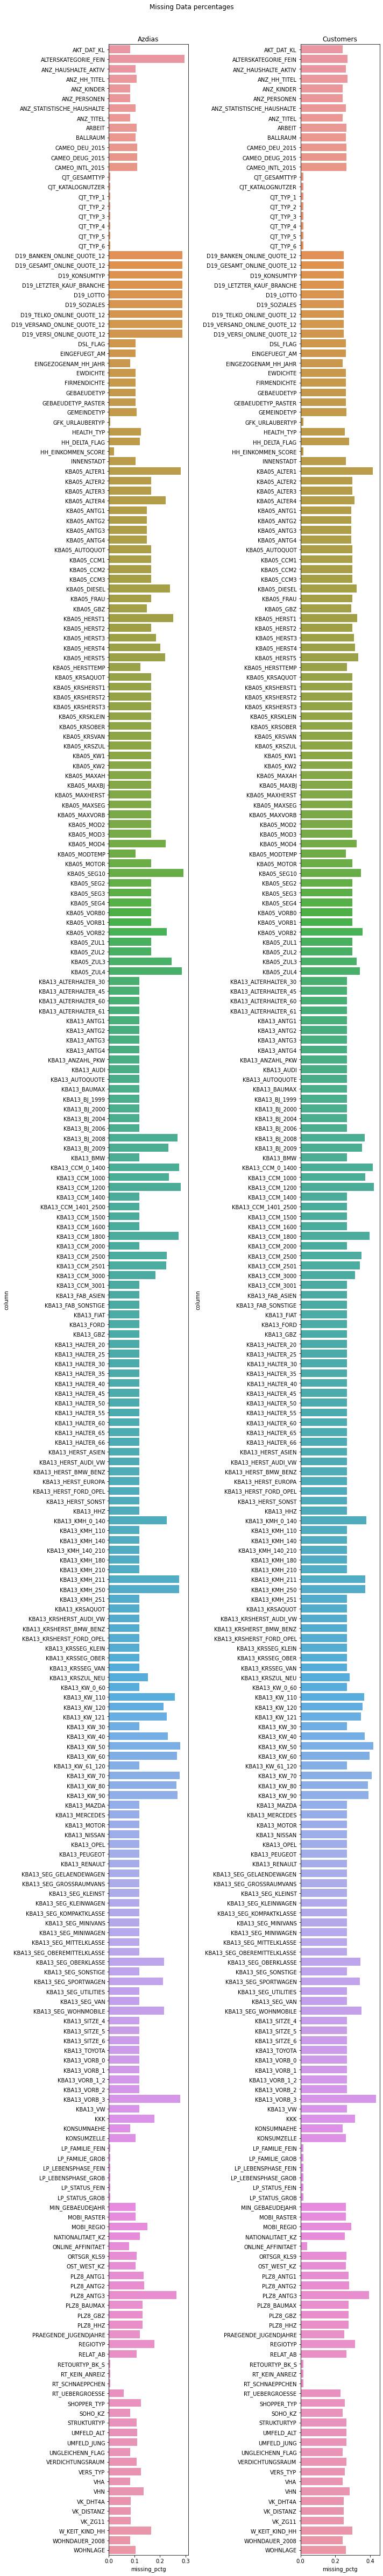

In [44]:
plot_missing_percentage(azdias, customers)

#### Remove rows with a high percentage of Null values

In [45]:
def get_missing_rows(data, threshold=50, verbose=False, debug=False):
    set_log_level(verbose, debug)
    timer.start()
    
    logger.info('Start labelling rows as missing')
    mask = _get_missing_count_row(data) > threshold 
    logger.debug('{} rows labelled as missing'.format(sum(mask)))
    
    logger.info('End labelling rows as missing in {} seconds'.format(timer.total()))
    return ~mask
    

def _get_missing_count_row(data):
    count_missing = data.isna().sum(axis=1)
    
    return count_missing


In [46]:
# missing rows in AZDIAS
rows_to_remove_azdias = get_missing_rows(azdias, verbose=True, debug=True)

UDACITY ARVATO PROJECT: 06/05/2021 23:00:25 - INFO: Start labelling rows as missing
UDACITY ARVATO PROJECT: 06/05/2021 23:00:27 - DEBUG: 150501 rows labelled as missing
UDACITY ARVATO PROJECT: 06/05/2021 23:00:27 - INFO: End labelling rows as missing in 1.52436 seconds


In [47]:
# missing rows in CUSTOMERS
rows_to_remove_customers = get_missing_rows(customers, verbose=True, debug=True)

UDACITY ARVATO PROJECT: 06/05/2021 23:00:27 - INFO: Start labelling rows as missing
UDACITY ARVATO PROJECT: 06/05/2021 23:00:27 - DEBUG: 57000 rows labelled as missing
UDACITY ARVATO PROJECT: 06/05/2021 23:00:27 - INFO: End labelling rows as missing in 0.32282 seconds


In [48]:
def drop_rows(data, mask, verbose=False, debug=False):
    set_log_level(verbose, debug)
    timer.start()
    
    logger.info('Start removing rows')
    data = data[mask]
    data = data.reset_index(drop=True)
    logger.debug('Removed {} rows'.format(len(data) - sum(mask)))
    
    logger.info('End removing rows in {} seconds'.format(timer.total()))
    return data


In [49]:
azdias = drop_rows(azdias, rows_to_remove_azdias, verbose=True, debug=True)

UDACITY ARVATO PROJECT: 06/05/2021 23:00:27 - INFO: Start removing rows
UDACITY ARVATO PROJECT: 06/05/2021 23:00:45 - DEBUG: Removed 0 rows
UDACITY ARVATO PROJECT: 06/05/2021 23:00:45 - INFO: End removing rows in 17.44949 seconds


In [50]:
customers = drop_rows(customers, rows_to_remove_customers, verbose=True, debug=True)

UDACITY ARVATO PROJECT: 06/05/2021 23:00:45 - INFO: Start removing rows
UDACITY ARVATO PROJECT: 06/05/2021 23:00:47 - DEBUG: Removed 0 rows
UDACITY ARVATO PROJECT: 06/05/2021 23:00:47 - INFO: End removing rows in 1.67841 seconds


#### Classify columns into Numerical or Categorical

In [51]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 740720 entries, 0 to 740719
Columns: 343 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(252), int64(87), object(4)
memory usage: 1.9+ GB


In [52]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134652 entries, 0 to 134651
Columns: 346 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(252), int64(88), object(6)
memory usage: 355.5+ MB


In [53]:
def _value_counts_by_column(data, columns):
    for col in columns:
        print("\nColumn ", col)
        print(azdias[col].value_counts())

def _columns_by_dtype(data, dtype, data_name):
    dtype_columns = data.columns[data.dtypes == dtype]
    print(data_name)
    print("Columns with object dtype: \n", dtype_columns.values)
    return dtype_columns.values


In [57]:
string_columns_azias = _columns_by_dtype(azdias, 'object', 'azdias')
string_columns_customers = _columns_by_dtype(customers, 'object', 'customers')

azdias
Columns with object dtype: 
 ['CAMEO_DEU_2015' 'D19_LETZTER_KAUF_BRANCHE' 'EINGEFUEGT_AM' 'OST_WEST_KZ']
customers
Columns with object dtype: 
 ['CAMEO_DEU_2015' 'D19_LETZTER_KAUF_BRANCHE' 'EINGEFUEGT_AM' 'OST_WEST_KZ']


Remove extra columns that exist in CUSTOMERS but not in AZDIAS

In [55]:
customers = drop_columns(customers, extra_columns)

UDACITY ARVATO PROJECT: 06/05/2021 23:00:47 - INFO: Start removing columns
UDACITY ARVATO PROJECT: 06/05/2021 23:00:48 - DEBUG: Removed columns: ['PRODUCT_GROUP', 'CUSTOMER_GROUP', 'ONLINE_PURCHASE']
UDACITY ARVATO PROJECT: 06/05/2021 23:00:48 - INFO: End removing columns in 0.23238 seconds


Explore the rest of the categorical columns

In [58]:
_value_counts_by_column(azdias, string_columns_azias)


Column  CAMEO_DEU_2015
6B    54098
8A    50974
4C    44053
2D    32951
7A    32730
      ...  
1C     4024
5F     3967
1B     3819
5E     3268
XX      284
Name: CAMEO_DEU_2015, Length: 45, dtype: int64

Column  D19_LETZTER_KAUF_BRANCHE
D19_UNBEKANNT         180754
D19_VERSICHERUNGEN     52395
D19_SONSTIGE           40763
D19_VOLLSORTIMENT      31427
D19_SCHUHE             28636
                       ...  
D19_BANKEN_LOKAL        1312
D19_BIO_OEKO            1098
D19_BILDUNG              880
D19_LOTTO                744
D19_KOSMETIK             714
Name: D19_LETZTER_KAUF_BRANCHE, Length: 35, dtype: int64

Column  EINGEFUEGT_AM
1992-02-10 00:00:00    374034
1992-02-12 00:00:00    188041
1995-02-07 00:00:00     10933
2003-11-18 00:00:00      5913
1993-03-01 00:00:00      3090
                        ...  
2001-02-01 00:00:00         1
2001-08-21 00:00:00         1
2001-04-20 00:00:00         1
2005-03-19 00:00:00         1
2001-03-20 00:00:00         1
Name: EINGEFUEGT_AM, Length: 2819,

#### Transforming Categorical columns into Numerical columns

We note that column EINGEFUEGT_AM is of type datetime. We can convert it to numeric, replacing it with the year.

In [59]:
def fix_datetime_columns(data, columns, verbose=False, debug=False):
    set_log_level(verbose, debug)
    timer.start()
    
    logger.info('Start fixing datetime columns')
    for column in columns:
        logger.debug('Fixing column {}'.format(column))
        data[column] = pd.to_datetime(data[column])
        data[column] = data[column].map(lambda x: x.year)
        logger.debug('{} column fixed in {} seconds'.format(column, timer.lapse()))
    
    logger.info('End fixing datetime columns in {} seconds'.format(timer.total()))
    return data


In [60]:
datetime_columns = ['EINGEFUEGT_AM']

In [61]:
azdias = fix_datetime_columns(azdias, datetime_columns, verbose=True, debug=True)

UDACITY ARVATO PROJECT: 06/05/2021 23:01:37 - INFO: Start fixing datetime columns
UDACITY ARVATO PROJECT: 06/05/2021 23:01:37 - DEBUG: Fixing column EINGEFUEGT_AM
UDACITY ARVATO PROJECT: 06/05/2021 23:01:41 - DEBUG: EINGEFUEGT_AM column fixed in 3.95058 seconds
UDACITY ARVATO PROJECT: 06/05/2021 23:01:41 - INFO: End fixing datetime columns in 3.95163 seconds


In [62]:
customers = fix_datetime_columns(customers, datetime_columns, verbose=True, debug=True)

UDACITY ARVATO PROJECT: 06/05/2021 23:01:41 - INFO: Start fixing datetime columns
UDACITY ARVATO PROJECT: 06/05/2021 23:01:41 - DEBUG: Fixing column EINGEFUEGT_AM
UDACITY ARVATO PROJECT: 06/05/2021 23:01:42 - DEBUG: EINGEFUEGT_AM column fixed in 0.70896 seconds
UDACITY ARVATO PROJECT: 06/05/2021 23:01:42 - INFO: End fixing datetime columns in 0.70969 seconds


We continue to analyse the rest of the categorical columns.

In [63]:
string_columns_azias = _columns_by_dtype(azdias, 'object', 'azdias')
string_columns_customers = _columns_by_dtype(customers, 'object', 'customers')

azdias
Columns with object dtype: 
 ['CAMEO_DEU_2015' 'D19_LETZTER_KAUF_BRANCHE' 'OST_WEST_KZ']
customers
Columns with object dtype: 
 ['CAMEO_DEU_2015' 'D19_LETZTER_KAUF_BRANCHE' 'OST_WEST_KZ']


In [64]:
_value_counts_by_column(azdias, string_columns_azias)


Column  CAMEO_DEU_2015
6B    54098
8A    50974
4C    44053
2D    32951
7A    32730
      ...  
1C     4024
5F     3967
1B     3819
5E     3268
XX      284
Name: CAMEO_DEU_2015, Length: 45, dtype: int64

Column  D19_LETZTER_KAUF_BRANCHE
D19_UNBEKANNT         180754
D19_VERSICHERUNGEN     52395
D19_SONSTIGE           40763
D19_VOLLSORTIMENT      31427
D19_SCHUHE             28636
                       ...  
D19_BANKEN_LOKAL        1312
D19_BIO_OEKO            1098
D19_BILDUNG              880
D19_LOTTO                744
D19_KOSMETIK             714
Name: D19_LETZTER_KAUF_BRANCHE, Length: 35, dtype: int64

Column  OST_WEST_KZ
W    584362
O    156358
Name: OST_WEST_KZ, dtype: int64


Now, we note that column D has only two categories, so it can be converted to binary.

In [65]:
def translate_columns(data, columns, labels, verbose=False, debug=False):
    set_log_level(verbose, debug)
    timer.start()
    
    logger.info('Start translating columns')
    for column in columns:
        logger.debug('Translating {} column'.format(column))
        data[column] = data[column].replace(labels[column])
        logger.debug('Translated {} column in {} seconds'.format(column, timer.lapse()))
    
    logger.info('End translating columns in {} seconds'.format(timer.total()))
    return data


In [66]:
columns_to_binarize = ['OST_WEST_KZ']
labels = {'OST_WEST_KZ': {"W": 0,
                          "O": 1}}

In [67]:
azdias = translate_columns(azdias, columns_to_binarize, labels, verbose=True, debug=True)

UDACITY ARVATO PROJECT: 06/05/2021 23:01:42 - INFO: Start translating columns
UDACITY ARVATO PROJECT: 06/05/2021 23:01:42 - DEBUG: Translating OST_WEST_KZ column
UDACITY ARVATO PROJECT: 06/05/2021 23:01:42 - DEBUG: Translated OST_WEST_KZ column in 0.25711 seconds
UDACITY ARVATO PROJECT: 06/05/2021 23:01:42 - INFO: End translating columns in 0.25791 seconds


In [68]:
customers = translate_columns(customers, columns_to_binarize, labels, verbose=True, debug=True)

UDACITY ARVATO PROJECT: 06/05/2021 23:01:42 - INFO: Start translating columns
UDACITY ARVATO PROJECT: 06/05/2021 23:01:42 - DEBUG: Translating OST_WEST_KZ column
UDACITY ARVATO PROJECT: 06/05/2021 23:01:42 - DEBUG: Translated OST_WEST_KZ column in 0.05067 seconds
UDACITY ARVATO PROJECT: 06/05/2021 23:01:42 - INFO: End translating columns in 0.0515 seconds


We continue to analyse the categorical columns

In [69]:
string_columns_azias = _columns_by_dtype(azdias, 'object', 'azdias')
string_columns_customers = _columns_by_dtype(customers, 'object', 'customers')

azdias
Columns with object dtype: 
 ['CAMEO_DEU_2015' 'D19_LETZTER_KAUF_BRANCHE']
customers
Columns with object dtype: 
 ['CAMEO_DEU_2015' 'D19_LETZTER_KAUF_BRANCHE']


In [70]:
_value_counts_by_column(azdias, string_columns_azias)


Column  CAMEO_DEU_2015
6B    54098
8A    50974
4C    44053
2D    32951
7A    32730
      ...  
1C     4024
5F     3967
1B     3819
5E     3268
XX      284
Name: CAMEO_DEU_2015, Length: 45, dtype: int64

Column  D19_LETZTER_KAUF_BRANCHE
D19_UNBEKANNT         180754
D19_VERSICHERUNGEN     52395
D19_SONSTIGE           40763
D19_VOLLSORTIMENT      31427
D19_SCHUHE             28636
                       ...  
D19_BANKEN_LOKAL        1312
D19_BIO_OEKO            1098
D19_BILDUNG              880
D19_LOTTO                744
D19_KOSMETIK             714
Name: D19_LETZTER_KAUF_BRANCHE, Length: 35, dtype: int64


We note that there are two categorical columns composed of more than two categories. To convert them to numerical, we will replace the values by ranking the number of occurrences of each category taking into account both datasets, and assigning a category 'other' as the value 0.

In [71]:
def categorical_to_numerical_transformation(data, columns, n_categories=20, verbose=False, debug=False):
    set_log_level(verbose, debug)
    timer.start()
    
    logger.info('Start getting translations from categorical to numerical columns')
    translation_dict = {}
    for column in columns:
        logger.debug('Getting translations from {} column'.format(column))
        translation_dict[column] = {}
        value_counts = data[column].value_counts().to_dict()
        for idx, item in enumerate(value_counts.keys()):
            if idx <= n_categories - 1:
                translation_dict[column][item] = idx + 1
            else:
                translation_dict[column][item] = 0
        logger.debug('Translations from {0} column obtained in {1} seconds'.format(column, timer.lapse()))
    
    logger.info('End getting translations from categorical to numerical columns in {} seconds'.format(timer.total()))
    return translation_dict


In [72]:
categorical_columns = ['CAMEO_DEU_2015', 'D19_LETZTER_KAUF_BRANCHE']

all_categorical_data = azdias[categorical_columns].append(customers[categorical_columns])

categorical_translation = categorical_to_numerical_transformation(all_categorical_data, categorical_columns,
                                                                  verbose=True, debug=True)

UDACITY ARVATO PROJECT: 06/05/2021 23:01:44 - INFO: Start getting translations from categorical to numerical columns
UDACITY ARVATO PROJECT: 06/05/2021 23:01:44 - DEBUG: Getting translations from CAMEO_DEU_2015 column
UDACITY ARVATO PROJECT: 06/05/2021 23:01:44 - DEBUG: Translations from CAMEO_DEU_2015 column obtained in 0.08355 seconds
UDACITY ARVATO PROJECT: 06/05/2021 23:01:44 - DEBUG: Getting translations from D19_LETZTER_KAUF_BRANCHE column
UDACITY ARVATO PROJECT: 06/05/2021 23:01:44 - DEBUG: Translations from D19_LETZTER_KAUF_BRANCHE column obtained in 0.08906 seconds
UDACITY ARVATO PROJECT: 06/05/2021 23:01:44 - INFO: End getting translations from categorical to numerical columns in 0.17321 seconds


In [73]:
azdias = translate_columns(azdias, categorical_columns, categorical_translation, verbose=True, debug=True)

UDACITY ARVATO PROJECT: 06/05/2021 23:01:44 - INFO: Start translating columns
UDACITY ARVATO PROJECT: 06/05/2021 23:01:44 - DEBUG: Translating CAMEO_DEU_2015 column
UDACITY ARVATO PROJECT: 06/05/2021 23:01:45 - DEBUG: Translated CAMEO_DEU_2015 column in 1.54496 seconds
UDACITY ARVATO PROJECT: 06/05/2021 23:01:45 - DEBUG: Translating D19_LETZTER_KAUF_BRANCHE column
UDACITY ARVATO PROJECT: 06/05/2021 23:01:46 - DEBUG: Translated D19_LETZTER_KAUF_BRANCHE column in 1.07572 seconds
UDACITY ARVATO PROJECT: 06/05/2021 23:01:46 - INFO: End translating columns in 2.62225 seconds


In [74]:
customers = translate_columns(customers, categorical_columns, categorical_translation, verbose=True, debug=True)

UDACITY ARVATO PROJECT: 06/05/2021 23:01:46 - INFO: Start translating columns
UDACITY ARVATO PROJECT: 06/05/2021 23:01:46 - DEBUG: Translating CAMEO_DEU_2015 column
UDACITY ARVATO PROJECT: 06/05/2021 23:01:47 - DEBUG: Translated CAMEO_DEU_2015 column in 0.32549 seconds
UDACITY ARVATO PROJECT: 06/05/2021 23:01:47 - DEBUG: Translating D19_LETZTER_KAUF_BRANCHE column
UDACITY ARVATO PROJECT: 06/05/2021 23:01:47 - DEBUG: Translated D19_LETZTER_KAUF_BRANCHE column in 0.20687 seconds
UDACITY ARVATO PROJECT: 06/05/2021 23:01:47 - INFO: End translating columns in 0.53361 seconds


Check that none of the datasets has any columns labelled as categorical.

In [75]:
string_columns_azias = _columns_by_dtype(azdias, 'object', 'azdias')
string_columns_customers = _columns_by_dtype(customers, 'object', 'customers')

azdias
Columns with object dtype: 
 []
customers
Columns with object dtype: 
 []


#### Check Id columns

LNR column corresponds to an id, so we must ensure that all values in that column are unique in both datasets.

In [76]:
def check_id_columns(data, columns, verbose=False, debug=False):
    set_log_level(verbose, debug)
    timer.start()
    
    logger.info('Start checking id columns')
    for column in columns:
        if len(data[column].unique()) != len(data):
            logger.warning('Not all values in {} column are unique'.format(column))
        else:
            logger.debug('All values in {} column are unique'.format(column))
    
    logger.info('End checking id columns in {} seconds'.format(timer.total()))


In [77]:
id_columns = ['LNR']

In [78]:
check_id_columns(azdias, id_columns, verbose=True, debug=True)

UDACITY ARVATO PROJECT: 06/05/2021 23:01:47 - INFO: Start checking id columns
UDACITY ARVATO PROJECT: 06/05/2021 23:01:47 - DEBUG: All values in LNR column are unique
UDACITY ARVATO PROJECT: 06/05/2021 23:01:47 - INFO: End checking id columns in 0.05038 seconds


In [79]:
check_id_columns(customers, id_columns, verbose=True, debug=True)

UDACITY ARVATO PROJECT: 06/05/2021 23:01:47 - INFO: Start checking id columns
UDACITY ARVATO PROJECT: 06/05/2021 23:01:47 - DEBUG: All values in LNR column are unique
UDACITY ARVATO PROJECT: 06/05/2021 23:01:47 - INFO: End checking id columns in 0.01296 seconds


#### Imputing missing values

In [80]:
def imputing_missing_values(data, strategy='most_frequent', verbose=False, debug=False):
    set_log_level(verbose, debug)
    timer.start()
    
    logger.info('Start imputing missing values with {} strategy'.format(strategy))
    imputer = SimpleImputer(strategy=strategy)
    data = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)
    
    logger.info('End imputing missing values with {} strategy in {} seconds'.format(strategy, timer.total()))
    return data


In [81]:
azdias = imputing_missing_values(azdias, verbose=True, debug=True)

UDACITY ARVATO PROJECT: 06/05/2021 23:01:47 - INFO: Start imputing missing values with most_frequent strategy
UDACITY ARVATO PROJECT: 06/05/2021 23:02:18 - INFO: End imputing missing values with most_frequent strategy in 30.73742 seconds


In [82]:
customers = imputing_missing_values(customers, verbose=True, debug=True)

UDACITY ARVATO PROJECT: 06/05/2021 23:02:18 - INFO: Start imputing missing values with most_frequent strategy
UDACITY ARVATO PROJECT: 06/05/2021 23:02:23 - INFO: End imputing missing values with most_frequent strategy in 4.58311 seconds


### 0.5. Feature Scaling

In [85]:
scaler = StandardScaler()

scaler.fit(azdias)

azdias = pd.DataFrame(scaler.transform(azdias), columns=azdias.columns)
customers = pd.DataFrame(scaler.transform(customers), columns=customers.columns)

In [86]:
azdias.head()

,LNR,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,...,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1.058544,1.261538,1.560538,0.181571,-0.126062,...,0.549044,-0.028609,1.139807,0.958494,-1.681975
1,1.058563,1.261538,0.674507,0.115748,-0.126062,...,0.549044,-1.083805,1.139807,0.958494,0.168090
2,1.058567,-0.935107,-0.211524,-0.476657,-0.126062,...,0.549044,1.554185,-0.281402,0.958494,1.093122
3,1.058625,-0.935107,0.009983,-0.345012,-0.126062,...,0.549044,-0.556207,0.429203,-1.043304,0.168090
4,1.058637,-0.935107,-0.876048,-0.213366,-0.126062,...,0.549044,1.554185,0.429203,0.958494,-1.681975


In [87]:
customers.head()

,LNR,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,...,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,-2.434344,-0.935107,-0.876048,-0.476657,-0.126062,...,0.549044,1.554185,-0.281402,-1.043304,1.093122
1,-1.913681,-0.935107,-3.091125,-0.476657,-0.126062,...,0.549044,-1.083805,-0.281402,0.958494,1.093122
2,-1.913677,-0.935107,-1.319063,-0.542480,-0.126062,...,0.549044,1.554185,-1.702612,-1.043304,1.093122
3,-1.913673,-0.935107,0.009983,-0.081721,-0.126062,...,0.549044,-0.556207,-1.702612,-1.043304,0.168090
4,-1.913619,-0.935107,-0.876048,-0.476657,-0.126062,...,0.549044,-1.611403,-0.992007,-1.043304,0.168090


### 0.6. Build a Function

Build a function that encompasses the stages of **Preprocessing**, **Univariate Analysis** and **Feature Scaling** optionally, in order to apply the same data cleaning process to all datasets used in this project.

In [88]:
UNKNOWN_VALUES = ['unknown', 'unknown / no main age detectable', 'numeric value', 'none']

TARGET_COLUMN = 'RESPONSE'
EXTRA_COLUMNS = ['PRODUCT_GROUP', 'CUSTOMER_GROUP', 'ONLINE_PURCHASE']
WARNING_COLUMNS = ['CAMEO_DEUG_2015', 'CAMEO_INTL_2015']
MISSING_COLUMNS = ['KBA05_ANHANG', 'ALTER_KIND2', 'KBA05_MOD1', 'KBA05_MOD8', 'KBA05_SEG1', 'TITEL_KZ',
                   'KBA05_KW3', 'KK_KUNDENTYP', 'PLZ8_ANTG4', 'KBA05_SEG9', 'KBA05_SEG8', 'ALTER_KIND4',
                   'KBA05_SEG7', 'KBA05_SEG6', 'ALTER_KIND3', 'ALTER_HH', 'KBA05_CCM4', 'KBA05_MOTRAD',
                   'ALTER_KIND1', 'EXTSEL992', 'KBA05_SEG5', 'AGER_TYP', 'KBA05_BAUMAX']
DATETIME_COLUMNS = ['EINGEFUEGT_AM']
BINARY_COLUMNS = ['OST_WEST_KZ']
CATEGORICAL_COLUMNS = ['CAMEO_DEU_2015', 'D19_LETZTER_KAUF_BRANCHE']
ID_COLUMNS = ['LNR']

TRANSLATIONS = {
    'OST_WEST_KZ': {"W": 0, "O": 1},
    'CAMEO_DEU_2015': {'6B': 1, '8A': 2, '4C': 3, '2D': 4, '3D': 5, '3C': 6, '4A': 7, '7A': 8, '8B': 9,
                       '8C': 10, '9D': 11, '9B': 12, '7B': 13, '9C': 14, '2C': 15, '9A': 16, '8D': 17,
                       '6E': 18, '5D': 19, '2B': 20, '1D': 0, '6C': 0, '2A': 0, '1A': 0, '5A': 0, '5B': 0,
                       '5C': 0, '4B': 0, '4D': 0, '7C': 0, '1E': 0, '3B': 0, '6A': 0, '3A': 0, '6D': 0,
                       '9E': 0, '4E': 0, '6F': 0, '1C': 0, '7D': 0, '7E': 0, '5F': 0, '1B': 0, '5E': 0, 'XX': 0
    },
    'D19_LETZTER_KAUF_BRANCHE': {'D19_UNBEKANNT': 1, 'D19_VERSICHERUNGEN': 2, 'D19_SONSTIGE': 3,
                                 'D19_VOLLSORTIMENT': 4, 'D19_BUCH_CD': 5, 'D19_SCHUHE': 6,
                                 'D19_VERSAND_REST': 7, 'D19_DROGERIEARTIKEL': 8, 'D19_HAUS_DEKO': 9,
                                 'D19_BANKEN_DIREKT': 10, 'D19_BEKLEIDUNG_REST': 11, 'D19_ENERGIE': 12,
                                 'D19_TELKO_MOBILE': 13, 'D19_BEKLEIDUNG_GEH': 14, 'D19_TELKO_REST': 15,
                                 'D19_BANKEN_GROSS': 16, 'D19_LEBENSMITTEL': 17, 'D19_TECHNIK': 18,
                                 'D19_FREIZEIT': 19, 'D19_KINDERARTIKEL': 20, 'D19_RATGEBER': 0, 
                                 'D19_BANKEN_REST': 0, 'D19_NAHRUNGSERGAENZUNG': 0, 'D19_DIGIT_SERV': 0,
                                 'D19_SAMMELARTIKEL': 0, 'D19_REISEN': 0, 'D19_WEIN_FEINKOST': 0,
                                 'D19_TIERARTIKEL': 0, 'D19_HANDWERK': 0, 'D19_GARTEN': 0, 'D19_BIO_OEKO': 0,
                                 'D19_BANKEN_LOKAL': 0, 'D19_BILDUNG': 0, 'D19_LOTTO': 0, 'D19_KOSMETIK': 0
                                }}


In [89]:
def preprocessing(data, metadata, verbose=False, debug=False):
    set_log_level(verbose, debug)
    timer.start()
    
    logger.info('Start Preprocessing')
    
    if not (data[WARNING_COLUMNS[0]].dtype == 'float64') & (data[WARNING_COLUMNS[1]].dtype == 'float64'):
        data = clean_warning_columns(data, WARNING_COLUMNS, verbose, debug)
    
    data = replace_unknown_values(data, metadata, UNKNOWN_VALUES, verbose, debug)
    
    logger.info('End Preprocessing in {} seconds'.format(timer.total()))
    return data
    
    
def univariate_analysis(data, missing_row_threshold=50, missing_values_strategy='most_frequent',
                        verbose=False, debug=False):
    set_log_level(verbose, debug)
    timer.start()
    
    logger.info('Start Univariate Analysis')
    
    logger.info('Removing missing columns: {}'.format(MISSING_COLUMNS))
    data = drop_columns(data, MISSING_COLUMNS, verbose, debug)
    
    missing_rows = get_missing_rows(data, missing_row_threshold, verbose, debug)
    data = drop_rows(data, missing_rows, verbose, debug)
    
    for extra_col in EXTRA_COLUMNS:
        if extra_col in list(data.columns):
            data = drop_columns(data, [extra_col], verbose, debug)
            
    data = fix_datetime_columns(data, DATETIME_COLUMNS, verbose, debug)
    
    binary_translations = {key: TRANSLATIONS[key] for key in BINARY_COLUMNS}
    data = translate_columns(data, BINARY_COLUMNS, binary_translations, verbose, debug)
    
    categorical_translation = {key: TRANSLATIONS[key] for key in CATEGORICAL_COLUMNS}
    data = translate_columns(data, CATEGORICAL_COLUMNS, categorical_translation, verbose, debug)
    
    check_id_columns(data, ID_COLUMNS, verbose, debug)
    
    data = imputing_missing_values(data, missing_values_strategy, verbose, debug)
    
    logger.info('End Univariate Analysis in {} seconds'.format(timer.total()))
    return data


def feature_scaling(data, scaler, verbose=False, debug=False):
    set_log_level(verbose, debug)
    timer.start()
    
    logger.info('Start Feature Scaling')
    
    data = pd.DataFrame(scaler.transform(data), columns=data.columns)
    
    logger.info('End Feature Scaling in {} seconds'.format(timer.total()))
    return data


#### Check Preprocessing and Univariate Analysis functions

In [90]:
# load in the data
# original_azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
# original_customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

original_azdias = pd.read_csv(r'./datasets/azdias.csv', index_col='Unnamed: 0')
original_customers = pd.read_csv(r'./datasets/customers.csv', index_col='Unnamed: 0')


C:\Users\magonzac\Anaconda3\envs\pruebas\lib\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (19,20) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [91]:
preprocessed_azdias = preprocessing(original_azdias, metadata_values, verbose=True, debug=False)

UDACITY ARVATO PROJECT: 06/05/2021 23:09:02 - INFO: Start Preprocessing
UDACITY ARVATO PROJECT: 06/05/2021 23:09:02 - INFO: Start cleaning warning columns
UDACITY ARVATO PROJECT: 06/05/2021 23:09:03 - INFO: End cleaning warning columns in 0.69575 seconds
UDACITY ARVATO PROJECT: 06/05/2021 23:09:03 - INFO: Start getting unkown categories from metadata
UDACITY ARVATO PROJECT: 06/05/2021 23:09:03 - INFO: End getting unkown categories from metadata in 0.03222 seconds
UDACITY ARVATO PROJECT: 06/05/2021 23:09:03 - INFO: Start replacing unkown values
UDACITY ARVATO PROJECT: 06/05/2021 23:11:53 - INFO: End replacing unkown values in 170.04871 seconds
UDACITY ARVATO PROJECT: 06/05/2021 23:11:53 - INFO: End Preprocessing in 170.0496 seconds


In [92]:
preprocessed_customers = preprocessing(original_customers, metadata_values, verbose=True, debug=False)

UDACITY ARVATO PROJECT: 06/05/2021 23:11:53 - INFO: Start Preprocessing
UDACITY ARVATO PROJECT: 06/05/2021 23:11:53 - INFO: Start cleaning warning columns
UDACITY ARVATO PROJECT: 06/05/2021 23:11:53 - INFO: End cleaning warning columns in 0.14144 seconds
UDACITY ARVATO PROJECT: 06/05/2021 23:11:53 - INFO: Start getting unkown categories from metadata
UDACITY ARVATO PROJECT: 06/05/2021 23:11:53 - INFO: End getting unkown categories from metadata in 0.00153 seconds
UDACITY ARVATO PROJECT: 06/05/2021 23:11:53 - INFO: Start replacing unkown values
UDACITY ARVATO PROJECT: 06/05/2021 23:13:26 - INFO: End replacing unkown values in 92.73969 seconds
UDACITY ARVATO PROJECT: 06/05/2021 23:13:26 - INFO: End Preprocessing in 92.74034 seconds


In [93]:
univariate_azdias = univariate_analysis(preprocessed_azdias, verbose=True, debug=False)

UDACITY ARVATO PROJECT: 06/05/2021 23:13:26 - INFO: Start Univariate Analysis
UDACITY ARVATO PROJECT: 06/05/2021 23:13:26 - INFO: Removing missing columns: ['KBA05_ANHANG', 'ALTER_KIND2', 'KBA05_MOD1', 'KBA05_MOD8', 'KBA05_SEG1', 'TITEL_KZ', 'KBA05_KW3', 'KK_KUNDENTYP', 'PLZ8_ANTG4', 'KBA05_SEG9', 'KBA05_SEG8', 'ALTER_KIND4', 'KBA05_SEG7', 'KBA05_SEG6', 'ALTER_KIND3', 'ALTER_HH', 'KBA05_CCM4', 'KBA05_MOTRAD', 'ALTER_KIND1', 'EXTSEL992', 'KBA05_SEG5', 'AGER_TYP', 'KBA05_BAUMAX']
UDACITY ARVATO PROJECT: 06/05/2021 23:13:26 - INFO: Start removing columns
UDACITY ARVATO PROJECT: 06/05/2021 23:13:38 - INFO: End removing columns in 12.05059 seconds
UDACITY ARVATO PROJECT: 06/05/2021 23:13:38 - INFO: Start labelling rows as missing
UDACITY ARVATO PROJECT: 06/05/2021 23:13:41 - INFO: End labelling rows as missing in 2.98828 seconds
UDACITY ARVATO PROJECT: 06/05/2021 23:13:41 - INFO: Start removing rows
UDACITY ARVATO PROJECT: 06/05/2021 23:13:50 - INFO: End removing rows in 8.8635 seconds
UDAC

In [94]:
univariate_customers = univariate_analysis(preprocessed_customers, verbose=True, debug=False)

UDACITY ARVATO PROJECT: 06/05/2021 23:14:31 - INFO: Start Univariate Analysis
UDACITY ARVATO PROJECT: 06/05/2021 23:14:31 - INFO: Removing missing columns: ['KBA05_ANHANG', 'ALTER_KIND2', 'KBA05_MOD1', 'KBA05_MOD8', 'KBA05_SEG1', 'TITEL_KZ', 'KBA05_KW3', 'KK_KUNDENTYP', 'PLZ8_ANTG4', 'KBA05_SEG9', 'KBA05_SEG8', 'ALTER_KIND4', 'KBA05_SEG7', 'KBA05_SEG6', 'ALTER_KIND3', 'ALTER_HH', 'KBA05_CCM4', 'KBA05_MOTRAD', 'ALTER_KIND1', 'EXTSEL992', 'KBA05_SEG5', 'AGER_TYP', 'KBA05_BAUMAX']
UDACITY ARVATO PROJECT: 06/05/2021 23:14:31 - INFO: Start removing columns
UDACITY ARVATO PROJECT: 06/05/2021 23:14:34 - INFO: End removing columns in 2.80775 seconds
UDACITY ARVATO PROJECT: 06/05/2021 23:14:34 - INFO: Start labelling rows as missing
UDACITY ARVATO PROJECT: 06/05/2021 23:14:34 - INFO: End labelling rows as missing in 0.32056 seconds
UDACITY ARVATO PROJECT: 06/05/2021 23:14:34 - INFO: Start removing rows
UDACITY ARVATO PROJECT: 06/05/2021 23:14:35 - INFO: End removing rows in 0.52022 seconds
UDAC

In [95]:
print('Shape of AZDIAS after notebook processing:', azdias.shape)
print('Shape of AZDIAS after Preprocessing and Univariate Analysis functions:', univariate_azdias.shape)

print('\nShape of CUSTOMERS after notebook processing:', customers.shape)
print('Shape of CUSTOMERS after Preprocessing and Univariate Analysis functions:', univariate_customers.shape)

Shape of AZDIAS after notebook processing: (740720, 343)
Shape of AZDIAS after Preprocessing and Univariate Analysis functions: (740720, 343)

Shape of CUSTOMERS after notebook processing: (134652, 343)
Shape of CUSTOMERS after Preprocessing and Univariate Analysis functions: (134652, 343)


#### Save datasets after Preprocessing and Univariate Analysis steps

In [96]:
univariate_azdias.to_csv('./datasets/univariate_azdias.csv', index=False)
univariate_customers.to_csv('./datasets/univariate_customers.csv', index=False)

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [229]:
# import libraries here; add more as necessary
import time
import logging
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier

from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

# magic word for producing visualizations in notebook
%matplotlib inline



#########################################################################
##########################      BASE
#########################################################################

def get_logger(level=logging.WARNING, force_level=False, name='logger'):
    
    logger_levels = [logging.CRITICAL, logging.ERROR, logging.WARNING,
                     logging.INFO, logging.DEBUG]
    
    if level not in logger_levels:
        raise ValueError('Invalid level name. Valid names {}'.format(logger_levels))
    
    formatter = 'UDACITY ARVATO PROJECT: %(asctime)s - %(levelname)s: %(message)s'
    date_format = '%d/%m/%Y %H:%M:%S'
    logging.basicConfig(format=formatter, datefmt=date_format, level=level)

    logger = logging.getLogger(name)
    if logger.getEffectiveLevel() == 0 or force_level:
        logger.setLevel(level)

    return logger


def set_log_level(verbose, debug):
    if verbose:
        get_logger(logging.INFO, force_level=True)
    if debug:
        get_logger(logging.DEBUG, force_level=True)

        
class Timer:
    
    def __init__(self, decimal_round=5):
        self.decimal_round = decimal_round

    def start(self):
        self.timer_start = time.perf_counter()
        self.timer_last = self.timer_start

    def lapse(self):
        last_lapse = self.timer_last
        self.timer_last = time.perf_counter()
        return round(self.timer_last - last_lapse, 5) 

    def total(self):
        return round(time.perf_counter() - self.timer_start, 5) 


    
#########################################################################
##########################      UTIL
#########################################################################

    
def print_df_full(data):
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_colwidth', None)
    
    display(data)
    
    pd.set_option('display.max_rows', 10)
    pd.set_option('display.max_columns', 10)
    pd.set_option('display.max_colwidth', 50)


def convert_to_numeric(string):
    try: 
        return float(string)
    except ValueError:
        return string

    
logger = get_logger()
timer = Timer(decimal_round=5)



#########################################################################
##########################      METADATA
#########################################################################

metadata_info_levels = pd.read_csv(r'./datasets/metadata/metadata_info_levels.txt', sep='\t', encoding='UTF-16')
metadata_values = pd.read_csv(r'./datasets/metadata/metadata_values.txt', sep='\t', encoding='UTF-16')
metadata_values['Attribute'] = metadata_values['Attribute'].ffill()



#########################################################################
##########################      CONSTANTS
#########################################################################

RANDOM_SEED = 14

UNKNOWN_VALUES = ['unknown', 'unknown / no main age detectable', 'numeric value', 'none']

TARGET_COLUMN = 'RESPONSE'
EXTRA_COLUMNS = ['PRODUCT_GROUP', 'CUSTOMER_GROUP', 'ONLINE_PURCHASE']
WARNING_COLUMNS = ['CAMEO_DEUG_2015', 'CAMEO_INTL_2015']
MISSING_COLUMNS = ['KBA05_ANHANG', 'ALTER_KIND2', 'KBA05_MOD1', 'KBA05_MOD8', 'KBA05_SEG1', 'TITEL_KZ',
                   'KBA05_KW3', 'KK_KUNDENTYP', 'PLZ8_ANTG4', 'KBA05_SEG9', 'KBA05_SEG8', 'ALTER_KIND4',
                   'KBA05_SEG7', 'KBA05_SEG6', 'ALTER_KIND3', 'ALTER_HH', 'KBA05_CCM4', 'KBA05_MOTRAD',
                   'ALTER_KIND1', 'EXTSEL992', 'KBA05_SEG5', 'AGER_TYP', 'KBA05_BAUMAX']
DATETIME_COLUMNS = ['EINGEFUEGT_AM']
BINARY_COLUMNS = ['OST_WEST_KZ']
CATEGORICAL_COLUMNS = ['CAMEO_DEU_2015', 'D19_LETZTER_KAUF_BRANCHE']
ID_COLUMN = 'LNR'
ID_COLUMNS = ['LNR']

TRANSLATIONS = {
    'OST_WEST_KZ': {"W": 0, "O": 1},
    'CAMEO_DEU_2015': {'6B': 1, '8A': 2, '4C': 3, '2D': 4, '3D': 5, '3C': 6, '4A': 7, '7A': 8, '8B': 9,
                       '8C': 10, '9D': 11, '9B': 12, '7B': 13, '9C': 14, '2C': 15, '9A': 16, '8D': 17,
                       '6E': 18, '5D': 19, '2B': 20, '1D': 0, '6C': 0, '2A': 0, '1A': 0, '5A': 0, '5B': 0,
                       '5C': 0, '4B': 0, '4D': 0, '7C': 0, '1E': 0, '3B': 0, '6A': 0, '3A': 0, '6D': 0,
                       '9E': 0, '4E': 0, '6F': 0, '1C': 0, '7D': 0, '7E': 0, '5F': 0, '1B': 0, '5E': 0, 'XX': 0
    },
    'D19_LETZTER_KAUF_BRANCHE': {'D19_UNBEKANNT': 1, 'D19_VERSICHERUNGEN': 2, 'D19_SONSTIGE': 3,
                                 'D19_VOLLSORTIMENT': 4, 'D19_BUCH_CD': 5, 'D19_SCHUHE': 6,
                                 'D19_VERSAND_REST': 7, 'D19_DROGERIEARTIKEL': 8, 'D19_HAUS_DEKO': 9,
                                 'D19_BANKEN_DIREKT': 10, 'D19_BEKLEIDUNG_REST': 11, 'D19_ENERGIE': 12,
                                 'D19_TELKO_MOBILE': 13, 'D19_BEKLEIDUNG_GEH': 14, 'D19_TELKO_REST': 15,
                                 'D19_BANKEN_GROSS': 16, 'D19_LEBENSMITTEL': 17, 'D19_TECHNIK': 18,
                                 'D19_FREIZEIT': 19, 'D19_KINDERARTIKEL': 20, 'D19_RATGEBER': 0, 
                                 'D19_BANKEN_REST': 0, 'D19_NAHRUNGSERGAENZUNG': 0, 'D19_DIGIT_SERV': 0,
                                 'D19_SAMMELARTIKEL': 0, 'D19_REISEN': 0, 'D19_WEIN_FEINKOST': 0,
                                 'D19_TIERARTIKEL': 0, 'D19_HANDWERK': 0, 'D19_GARTEN': 0, 'D19_BIO_OEKO': 0,
                                 'D19_BANKEN_LOKAL': 0, 'D19_BILDUNG': 0, 'D19_LOTTO': 0, 'D19_KOSMETIK': 0
                                }}



#########################################################################
##########################      PREPROCESSING
#########################################################################

def clean_warning_columns(df, columns, verbose=False, debug=False):
    """
    Function to replace 'X', 'XX' and 'nan' values with -1 
    and change the data type to float.
    """
    set_log_level(verbose, debug)
    timer.start()
    
    logger.info('Start cleaning warning columns')
    
    logger.debug('Replacing "X", "XX" and "nan" values with -1')
    replacements = {"X": np.nan, "XX": np.nan}
    df[columns] = df[columns].replace(replacements)
    logger.debug('Replaced columns: {0} in {1} seconds'.format(list(columns), timer.lapse()))
    
    logger.debug('Changing data type to float')
    df[columns] = df[columns].astype(float)
    logger.debug('Changed data type to float in {} seconds'.format(timer.lapse()))
    
    logger.info('End cleaning warning columns in {} seconds'.format(timer.total()))
    return df


def replace_unknown_values(data, metadata, unknown_values, verbose=False, debug=False):
    set_log_level(verbose, debug)
    timer.start()
    
    unknown_data = get_unkown_values_data(metadata, unknown_values, verbose=verbose, debug=debug)
    
    logger.info('Start replacing unkown values')
    
    for attribute in unknown_data['Attribute']:
        
        if attribute in data.columns:
            unknown_categories = _get_categories(unknown_data, attribute)
            data[attribute] = data[attribute].apply(lambda x: np.nan if x in unknown_categories[attribute] else x)
            
            logger.debug('Replaced {0} to NaN in {1} column in {2} seconds'.format(
                unknown_categories[attribute], attribute, timer.lapse()))
        else:
            logger.debug('Attribute {} not in data'.format(attribute))
    
    logger.info('End replacing unkown values in {} seconds'.format(timer.total()))
    return data


def _get_categories(data, attribute):
    output = {}
    for attribute in data['Attribute']:
        categories = data[data['Attribute'] == attribute]['Value']
        categories = categories.astype(str).str.cat(sep=', ')
        categories = [str(x).strip() for x in categories.split(', ')]

        output[attribute] = [convert_to_numeric(x) for x in categories]
    return output


def get_unkown_values_data(metadata, unkown_categories, verbose=False, debug=False):
    set_log_level(verbose, debug)
    timer.start()
    
    logger.info('Start getting unkown categories from metadata')
    
    unknown_values = metadata[metadata['Meaning'].isin(unkown_categories)]
    unknown_values = unknown_values.reset_index(drop=True)
    logger.debug('Number of features with unknown categories:'.format(len(unknown_values)))
    
    logger.info('End getting unkown categories from metadata in {} seconds'.format(timer.total()))
    return unknown_values



def preprocessing(data, metadata, verbose=False, debug=False):
    set_log_level(verbose, debug)
    timer.start()
    
    logger.info('Start Preprocessing')
    
    if not (data[WARNING_COLUMNS[0]].dtype == 'float64') & (data[WARNING_COLUMNS[1]].dtype == 'float64'):
        data = clean_warning_columns(data, WARNING_COLUMNS, verbose, debug)
    
    data = replace_unknown_values(data, metadata, UNKNOWN_VALUES, verbose, debug)
    
    logger.info('End Preprocessing in {} seconds'.format(timer.total()))
    return data
    



#########################################################################
##########################      UNIVARIATE ANALYSIS
#########################################################################

def drop_columns(data, column_list, verbose=False, debug=False):
    set_log_level(verbose, debug)
    timer.start()
    
    logger.info('Start removing columns')
    
    data = data.drop(column_list, axis=1)
    logger.debug('Removed columns: {}'.format(column_list))
    
    logger.info('End removing columns in {} seconds'.format(timer.total()))
    return data


def get_missing_rows(data, threshold=50, verbose=False, debug=False):
    set_log_level(verbose, debug)
    timer.start()
    
    logger.info('Start labelling rows as missing')
    mask = _get_missing_count_row(data) > threshold 
    logger.debug('{} rows labelled as missing'.format(sum(mask)))
    
    logger.info('End labelling rows as missing in {} seconds'.format(timer.total()))
    return ~mask
    

def _get_missing_count_row(data):
    count_missing = data.isna().sum(axis=1)
    
    return count_missing


def drop_rows(data, mask, verbose=False, debug=False):
    set_log_level(verbose, debug)
    timer.start()
    
    logger.info('Start removing rows')
    data = data[mask]
    data = data.reset_index(drop=True)
    logger.debug('Removed {} rows'.format(len(data) - sum(mask)))
    
    logger.info('End removing rows in {} seconds'.format(timer.total()))
    return data


def fix_datetime_columns(data, columns, verbose=False, debug=False):
    set_log_level(verbose, debug)
    timer.start()
    
    logger.info('Start fixing datetime columns')
    for column in columns:
        logger.debug('Fixing column {}'.format(column))
        data[column] = pd.to_datetime(data[column])
        data[column] = data[column].map(lambda x: x.year)
        logger.debug('{} column fixed in {} seconds'.format(column, timer.lapse()))
    
    logger.info('End fixing datetime columns in {} seconds'.format(timer.total()))
    return data


def translate_columns(data, columns, labels, verbose=False, debug=False):
    set_log_level(verbose, debug)
    timer.start()
    
    logger.info('Start translating columns')
    for column in columns:
        logger.debug('Translating {} column'.format(column))
        data[column] = data[column].replace(labels[column])
        logger.debug('Translated {} column in {} seconds'.format(column, timer.lapse()))
    
    logger.info('End translating columns in {} seconds'.format(timer.total()))
    return data


def check_id_columns(data, columns, verbose=False, debug=False):
    set_log_level(verbose, debug)
    timer.start()
    
    logger.info('Start checking id columns')
    for column in columns:
        if len(data[column].unique()) != len(data):
            logger.warning('Not all values in {} column are unique'.format(column))
        else:
            logger.debug('All values in {} column are unique'.format(column))
    
    logger.info('End checking id columns in {} seconds'.format(timer.total()))


def imputing_missing_values(data, strategy='most_frequent', verbose=False, debug=False):
    set_log_level(verbose, debug)
    timer.start()
    
    logger.info('Start imputing missing values with {} strategy'.format(strategy))
    imputer = SimpleImputer(strategy=strategy)
    data = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)
    
    logger.info('End imputing missing values with {} strategy in {} seconds'.format(strategy, timer.total()))
    return data



def univariate_analysis(data, missing_row_threshold=50, missing_values_strategy='most_frequent',
                        verbose=False, debug=False):
    set_log_level(verbose, debug)
    timer.start()
    
    logger.info('Start Univariate Analysis')
    
    logger.info('Removing missing columns: {}'.format(MISSING_COLUMNS))
    data = drop_columns(data, MISSING_COLUMNS, verbose, debug)
    
    if missing_row_threshold is None:
        missing_row_threshold = len(data)
    
    missing_rows = get_missing_rows(data, missing_row_threshold, verbose, debug)
    data = drop_rows(data, missing_rows, verbose, debug)
    
    for extra_col in EXTRA_COLUMNS:
        if extra_col in list(data.columns):
            data = drop_columns(data, [extra_col], verbose, debug)
            
    data = fix_datetime_columns(data, DATETIME_COLUMNS, verbose, debug)
    
    binary_translations = {key: TRANSLATIONS[key] for key in BINARY_COLUMNS}
    data = translate_columns(data, BINARY_COLUMNS, binary_translations, verbose, debug)
    
    categorical_translation = {key: TRANSLATIONS[key] for key in CATEGORICAL_COLUMNS}
    data = translate_columns(data, CATEGORICAL_COLUMNS, categorical_translation, verbose, debug)
    
    check_id_columns(data, ID_COLUMNS, verbose, debug)
    
    data = imputing_missing_values(data, missing_values_strategy, verbose, debug)
    
    logger.info('End Univariate Analysis in {} seconds'.format(timer.total()))
    return data



#########################################################################
##########################      FEATURE SCALING
#########################################################################

def feature_scaling(data, scaler, verbose=False, debug=False):
    set_log_level(verbose, debug)
    timer.start()
    
    logger.info('Start Feature Scaling')
    
    data = pd.DataFrame(scaler.transform(data), columns=data.columns)
    
    logger.info('End Feature Scaling in {} seconds'.format(timer.total()))
    return data




In [2]:
#########################################################################
##########################      PCA
#########################################################################


univariate_azdias = pd.read_csv('./datasets/univariate_azdias.csv')
univariate_customers = pd.read_csv('./datasets/univariate_customers.csv')

scaler = StandardScaler()
scaler.fit(univariate_azdias)

univariate_azdias = feature_scaling(univariate_azdias, scaler, verbose=True, debug=True)

def pca_analysis(data, n_components=None, random_seed=RANDOM_SEED, verbose=False, debug=False):
    set_log_level(verbose, debug)
    timer.start()
    
    logger.info('Start PCA analysis')
    pca = PCA(n_components, random_state=random_seed)
    pca.fit(data)
    data_transformed = pca.transform(data)
    
    logger.info('End PCA analysis in {} seconds'.format(timer.total()))
    return pca, data_transformed


pca_150, azdias_pca_150 = pca_analysis(univariate_azdias, n_components=150, verbose=True, debug=True)






UDACITY ARVATO PROJECT: 11/05/2021 18:25:34 - INFO: Start Feature Scaling
UDACITY ARVATO PROJECT: 11/05/2021 18:25:38 - INFO: End Feature Scaling in 4.38696 seconds
UDACITY ARVATO PROJECT: 11/05/2021 18:25:38 - INFO: Start PCA analysis
UDACITY ARVATO PROJECT: 11/05/2021 18:28:42 - INFO: End PCA analysis in 183.45273 seconds


#### Load clean datasets

In [3]:
univariate_azdias = pd.read_csv('./datasets/univariate_azdias.csv')
univariate_customers = pd.read_csv('./datasets/univariate_customers.csv')

In [4]:
univariate_azdias.head()

,LNR,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910220.0,9.0,21.0,11.0,0.0,0.0,2.0,12.0,0.0,3.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5.0,2.0,1.0
1,910225.0,9.0,17.0,10.0,0.0,0.0,1.0,7.0,0.0,3.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5.0,2.0,3.0
2,910226.0,1.0,13.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,...,0.0,7.0,10.0,11.0,6.0,9.0,7.0,3.0,2.0,4.0
3,910241.0,1.0,14.0,3.0,0.0,0.0,4.0,3.0,0.0,4.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4.0,1.0,3.0
4,910244.0,1.0,10.0,5.0,0.0,0.0,1.0,2.0,0.0,2.0,...,2.0,10.0,7.0,4.0,6.0,9.0,7.0,4.0,2.0,1.0


In [5]:
univariate_customers.head()

,LNR,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626.0,1.0,10.0,1.0,0.0,0.0,2.0,1.0,0.0,1.0,...,3.0,5.0,3.0,2.0,6.0,9.0,7.0,3.0,1.0,4.0
1,143872.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,3.0,...,4.0,10.0,13.0,11.0,6.0,9.0,2.0,3.0,2.0,4.0
2,143873.0,1.0,8.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,2.0,6.0,4.0,2.0,6.0,9.0,7.0,1.0,1.0,4.0
3,143874.0,1.0,14.0,7.0,0.0,0.0,4.0,7.0,0.0,3.0,...,4.0,3.0,5.0,4.0,2.0,9.0,3.0,1.0,1.0,3.0
4,143888.0,1.0,10.0,1.0,0.0,0.0,2.0,1.0,0.0,3.0,...,4.0,1.0,2.0,1.0,6.0,9.0,1.0,2.0,1.0,3.0


#### Scaling data

In [6]:
scaler = StandardScaler()
scaler.fit(univariate_azdias)

StandardScaler()

In [7]:
univariate_azdias = feature_scaling(univariate_azdias, scaler, verbose=True, debug=True)

UDACITY ARVATO PROJECT: 11/05/2021 18:29:23 - INFO: Start Feature Scaling
UDACITY ARVATO PROJECT: 11/05/2021 18:29:25 - INFO: End Feature Scaling in 2.23126 seconds


In [8]:
univariate_customers = feature_scaling(univariate_customers, scaler, verbose=True, debug=True)

UDACITY ARVATO PROJECT: 11/05/2021 18:29:25 - INFO: Start Feature Scaling
UDACITY ARVATO PROJECT: 11/05/2021 18:29:26 - INFO: End Feature Scaling in 0.46117 seconds


### 1.1. Principal Component Analysis

In [57]:
def pca_analysis(data, n_components=None, random_seed=RANDOM_SEED, verbose=False, debug=False):
    set_log_level(verbose, debug)
    timer.start()
    
    logger.info('Start PCA analysis')
    pca = PCA(n_components, random_state=random_seed)
    pca.fit(data)
    data_transformed = pca.transform(data)
    
    logger.info('End PCA analysis in {} seconds'.format(timer.total()))
    return pca, data_transformed
    

In [46]:
pca_all, _ = pca_analysis(univariate_azdias, verbose=True, debug=True)

UDACITY ARVATO PROJECT: 10/05/2021 20:47:01 - INFO: Start PCA analysis
UDACITY ARVATO PROJECT: 10/05/2021 20:48:53 - INFO: End PCA analysis in 112.43696 seconds


In [10]:
def plot_exp_pca_variance(pca_object, cumulative=True): 
    
    if cumulative:
        data_variance = np.cumsum(pca_object.explained_variance_ratio_)
        y_label = "Percentage Explained Variance"
    else:
        data_variance = pca_object.explained_variance_ratio_
        y_label = "Explained Variance Ratio"
        
    fig = plt.figure(figsize=(8, 10))

    ax = fig.add_subplot(211)
    ax.plot(data_variance)
    ax.set_xlabel("No. of components")
    ax.set_ylabel(y_label)
    ax.set_title("PCA Explained Variance Ratio vs Number of Components")
    ax.grid()
    plt.show()


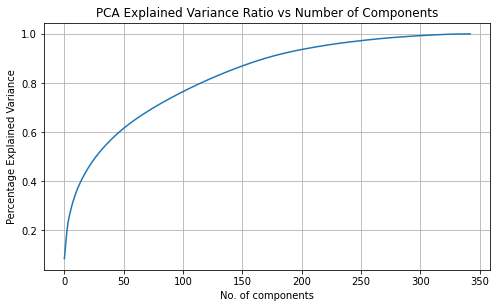

In [11]:
plot_exp_pca_variance(pca_all, True)

In the graph above we can see that 150 variables explain around 90% of variance in the dataset, it can be a good choice.

In [47]:
pca_150, azdias_pca_150 = pca_analysis(univariate_azdias, n_components=150, verbose=True, debug=True)

UDACITY ARVATO PROJECT: 10/05/2021 20:48:54 - INFO: Start PCA analysis
UDACITY ARVATO PROJECT: 10/05/2021 20:51:37 - INFO: End PCA analysis in 163.22236 seconds


#### 1.1.1. Interpreting PCA components

In [113]:
def get_feature_weights(data, pca_object, metadata, component, n_weights=5,
                        verbose=False, debug=False):
    set_log_level(verbose, debug)
    timer.start()
    
    logger.info('Start getting feature weights for component {}'.format(component))
    
    features = data.columns.values
    components = pca_object.components_
    
    feature_weights = dict(zip(features, components[component]))
    sorted_weights = sorted(feature_weights.items(), key = lambda x: x[1])
    
    feature_name = []
    feature_weight = []
    feature_description = []

    for feature, weight in sorted_weights[-n_weights:]:
        feature_name.append(feature)
        feature_weight.append(weight)
        
    for feature, weight, in sorted_weights[:n_weights]:
        feature_name.append(feature)
        feature_weight.append(weight)
        
    for feature in feature_name:
        if feature in metadata.Attribute.values:
            feature_description.append(metadata[metadata['Attribute'] == feature]['Description'].values[0])
        else:
            feature_description.append('No description given')
    
    component_info = {'Feature': feature_name,
                      'Description': feature_description,
                      'Feature Weight': feature_weight}
    component_info = pd.DataFrame(component_info)
    component_info.sort_values('Feature Weight', inplace=True, ascending=False, ignore_index=True)
    
    logger.info('End getting feature weights for component {} in {} seconds'.format(component, timer.total()))
    return component_info


In [110]:
def plot_feature_weights(component_info, component, n_weights=5):
    
    feature_names = component_info['Feature'].values
    feature_weights = component_info['Feature Weight'].values
    
    fig = plt.figure(figsize=(7, 8))

    ax = fig.add_subplot(211)
    ax.bar(feature_names, feature_weights)
    ax.set_ylabel("Feature Weight")
    ax.set_xlabel("Feature Name")
    ax.set_title("PCA Feature weights - Component {}".format(component))
    
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
        
    ax.grid()
    fig.tight_layout()
    plt.show()


##### Component 0

In [111]:
component = 0
n_weights = 4

In [114]:
comp_0_info = get_feature_weights(univariate_azdias, pca_all, metadata_info_levels, component, n_weights,
                                  verbose=True, debug=True)
print_df_full(comp_0_info)

UDACITY ARVATO PROJECT: 06/05/2021 23:53:13 - INFO: Start getting feature weights for component 0
UDACITY ARVATO PROJECT: 06/05/2021 23:53:13 - INFO: End getting feature weights for component 0 in 0.01694 seconds


,Feature,Description,Feature Weight
0,MOBI_REGIO,moving patterns,0.134626
1,KBA13_ANTG1,No description given,0.126866
2,LP_STATUS_FEIN,social status fine,0.126778
3,PLZ8_ANTG1,number of 1-2 family houses in the PLZ8,0.126693
4,CAMEO_DEUG_2015,CAMEO_4.0: uppergroup,-0.121384
5,KBA13_BAUMAX,No description given,-0.121810
6,HH_EINKOMMEN_SCORE,estimated household_net_income,-0.122737
7,KBA13_ANTG3,No description given,-0.125026


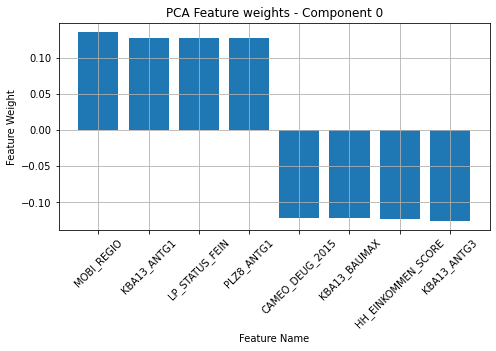

In [115]:
plot_feature_weights(comp_0_info, component, n_weights)

- Has a positive weight to moving patterns and social status fine of people.
- Has a positive weight to number of 1-2 family houses in the neighbourhood.
- Has a negative weight the estimated household net income.

##### Component 1

In [116]:
component = 1
n_weights = 4

In [117]:
comp_1_info = get_feature_weights(univariate_azdias, pca_all, metadata_info_levels, component, n_weights,
                                  verbose=True, debug=True)
print_df_full(comp_1_info)

UDACITY ARVATO PROJECT: 06/05/2021 23:53:16 - INFO: Start getting feature weights for component 1
UDACITY ARVATO PROJECT: 06/05/2021 23:53:16 - INFO: End getting feature weights for component 1 in 0.00866 seconds


,Feature,Description,Feature Weight
0,D19_GESAMT_ANZ_24,No description given,0.136826
1,D19_GESAMT_ANZ_12,No description given,0.129239
2,D19_VERSAND_ANZ_24,No description given,0.124030
3,PRAEGENDE_JUGENDJAHRE,dominating movement in the person's youth (avantgarde or mainstream),0.122304
4,D19_VERSAND_DATUM,actuality of the last transaction for the segment mail-order TOTAL,-0.124743
5,D19_GESAMT_DATUM,actuality of the last transaction with the complete file TOTAL,-0.126626
6,D19_VERSAND_ONLINE_DATUM,actuality of the last transaction for the segment mail-order ONLINE,-0.127532
7,D19_GESAMT_ONLINE_DATUM,actuality of the last transaction with the complete file ONLINE,-0.132403


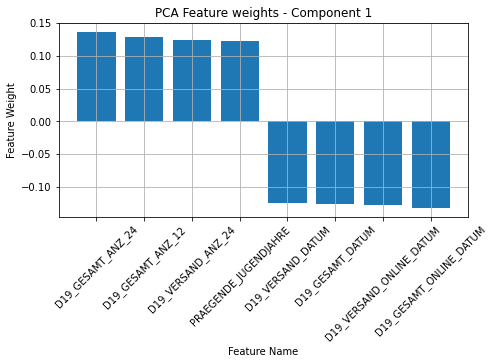

In [118]:
plot_feature_weights(comp_1_info, component, n_weights)

- Has a positive weight the dominating movement in the person's youth (avantgarde or mainstream).
- Negative weights are closely related to the actuality of the last transaction, for the segment mail-order or with the complete file.

### 1.2. K-Means Clustering

After having reduced the demographic dataset to principal components, we will use a K-Means model to segment the population.

#### 1.2.1. Select optimal K value with AZDIAS_PCA data

In [119]:
def get_kmeans_scores(data, k_start, k_end, step=1, random_seed=RANDOM_SEED, verbose=False, debug=False):
    set_log_level(verbose, debug)
    timer.start()
    
    logger.info('Start performing K-Means clustering')
    logger.info('Given range min:{}, max:{}, step:{}'.format(k_start, k_end, step))
    
    scores = []
    for n in range(k_start, k_end+1, step):
        
        logger.debug('Training for n_clusters: {}'.format(n))
        
        kmeans = KMeans(n, random_state=random_seed)
        model = kmeans.fit(data)
        scores.append(abs(model.score(data)))
        
        logger.debug('Score: {}'.format(scores[-1]))
        logger.debug('Trained for n_clusters: {} in {} seconds'.format(n, timer.lapse()))
    
    logger.info('End performing K-Means clustering in {} seconds'.format(timer.total()))
    return scores, range(k_start, k_end+1, step)


In [120]:
scores_150, range_150 = get_kmeans_scores(azdias_pca_150, k_start=2, k_end=20, verbose=True, debug=True)

UDACITY ARVATO PROJECT: 06/05/2021 23:57:47 - INFO: Start performing K-Means clustering
UDACITY ARVATO PROJECT: 06/05/2021 23:57:47 - INFO: Given range min:2, max:20, step:1
UDACITY ARVATO PROJECT: 06/05/2021 23:57:47 - DEBUG: Training for n_clusters: 2
UDACITY ARVATO PROJECT: 06/05/2021 23:58:11 - DEBUG: Score: 204881034.88266832
UDACITY ARVATO PROJECT: 06/05/2021 23:58:11 - DEBUG: Trained for n_clusters: 2 in 23.77937 seconds
UDACITY ARVATO PROJECT: 06/05/2021 23:58:11 - DEBUG: Training for n_clusters: 3
UDACITY ARVATO PROJECT: 06/05/2021 23:58:45 - DEBUG: Score: 196965692.04945916
UDACITY ARVATO PROJECT: 06/05/2021 23:58:45 - DEBUG: Trained for n_clusters: 3 in 34.00428 seconds
UDACITY ARVATO PROJECT: 06/05/2021 23:58:45 - DEBUG: Training for n_clusters: 4
UDACITY ARVATO PROJECT: 06/05/2021 23:59:41 - DEBUG: Score: 192339868.34837452
UDACITY ARVATO PROJECT: 06/05/2021 23:59:41 - DEBUG: Trained for n_clusters: 4 in 56.35718 seconds
UDACITY ARVATO PROJECT: 06/05/2021 23:59:41 - DEBUG:

In [121]:
def plot_elbow(scores, range_):
    
    fig = plt.figure(figsize=(15, 6))
    ax = fig.add_subplot(111)
    
    major_ticks = np.arange(0, 20, 1)
    ax.set_xticks(major_ticks)
    
    ax.plot(range_, scores, linestyle='-',marker='o', color='blue')
    ax.set_xlabel('Number of Clusters')
    ax.set_ylabel('Sum of squared distances')
    ax.set_title('Kmeans - Cluster distances vs Number of Clusters')
    ax.grid(which='major', color='black', linestyle='--', alpha=0.5)
    
    plt.show()


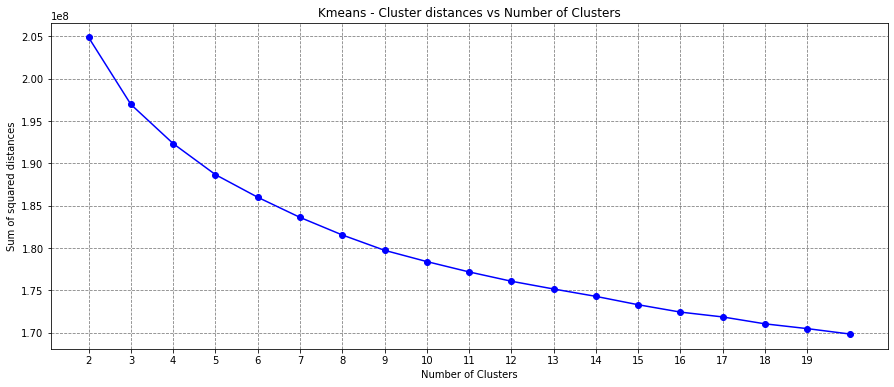

In [122]:
plot_elbow(scores_150, range_150)

##### Choosing Number of Clusters

In [123]:
n_clusters = 8

#### 1.2.2. Fit K-Means object with optimal K and AZDIAS PCA data

In [124]:
k_means = KMeans(n_clusters, random_state=14)
k_means.fit(azdias_pca_150)

KMeans(random_state=14)

#### 1.2.3. Get AZDIAS PCA and CUSTOMERS PCA Clusters

##### AZDIAS Clusters

In [125]:
azdias_clusters = k_means.predict(azdias_pca_150)
azdias_clusters = pd.Series(azdias_clusters)

##### CUSTOMERS Clusters

In [126]:
customers_pca_150 = pca_150.transform(univariate_customers)

In [127]:
customers_clusters = k_means.predict(customers_pca_150)
customers_clusters = pd.Series(customers_clusters)

##### Check results

In [128]:
azdias_clusters_values = azdias_clusters.value_counts().sort_index()
azdias_clusters_values

0     64393
1     77341
2    115835
3     94867
4     89891
5    114898
6    117709
7     65786
dtype: int64

In [129]:
customers_clusters_values = customers_clusters.value_counts().sort_index()
customers_clusters_values

0    25002
1     3907
2    42911
3    15859
4     2036
5     1167
6    39568
7     4202
dtype: int64

In [130]:
df_clusters = pd.DataFrame.from_dict({'Cluster': list(range(0, n_clusters)), 
                                      'Azdias': azdias_clusters_values,
                                      'Customers': customers_clusters_values
                                     })
df_clusters

,Cluster,Azdias,Customers
0,0,64393,25002
1,1,77341,3907
2,2,115835,42911
3,3,94867,15859
4,4,89891,2036
5,5,114898,1167
6,6,117709,39568
7,7,65786,4202


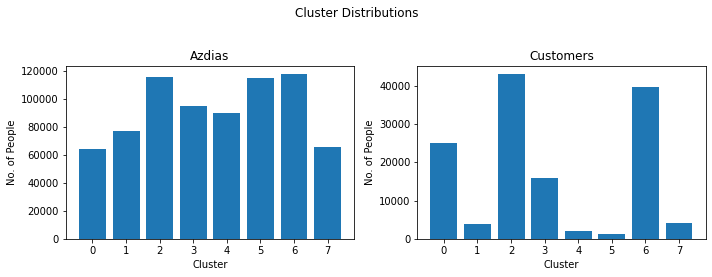

In [131]:
fig, (ax_1, ax_2) = plt.subplots(1, 2, figsize=(10, 4))

ax_1.bar(df_clusters["Cluster"], df_clusters["Azdias"])
ax_1.set_xlabel("Cluster")
ax_1.set_ylabel("No. of People")
ax_1.set_title("Azdias")

ax_2.bar(df_clusters["Cluster"], df_clusters["Customers"])
ax_2.set_xlabel("Cluster")
ax_2.set_ylabel("No. of People")
ax_2.set_title("Customers")

fig.suptitle("Cluster Distributions")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

#### 1.2.4. Get ratio between customers and general population for each Cluster

In [132]:
total_azdias = azdias_clusters_values.sum()
total_customers = customers_clusters_values.sum()

print('Total number of people in Azdias dataset:', total_azdias)
print('Total number of people in Customers dataset:', total_customers)

Total number of people in Azdias dataset: 740720
Total number of people in Customers dataset: 134652


In [133]:
df_clusters['Azdias_pctg'] = ((df_clusters['Azdias'] / total_azdias) * 100).round(2)
df_clusters['Customers_pctg'] = ((df_clusters['Customers'] / total_customers) * 100).round(2)

df_clusters

,Cluster,Azdias,Customers,Azdias_pctg,Customers_pctg
0,0,64393,25002,8.69,18.57
1,1,77341,3907,10.44,2.90
2,2,115835,42911,15.64,31.87
3,3,94867,15859,12.81,11.78
4,4,89891,2036,12.14,1.51
5,5,114898,1167,15.51,0.87
6,6,117709,39568,15.89,29.39
7,7,65786,4202,8.88,3.12


In [134]:
df_clusters["ratio"] = df_clusters["Customers_pctg"] / df_clusters["Azdias_pctg"]

df_clusters

,Cluster,Azdias,Customers,Azdias_pctg,Customers_pctg,ratio
0,0,64393,25002,8.69,18.57,2.136939
1,1,77341,3907,10.44,2.90,0.277778
2,2,115835,42911,15.64,31.87,2.037724
3,3,94867,15859,12.81,11.78,0.919594
4,4,89891,2036,12.14,1.51,0.124382
5,5,114898,1167,15.51,0.87,0.056093
6,6,117709,39568,15.89,29.39,1.849591
7,7,65786,4202,8.88,3.12,0.351351


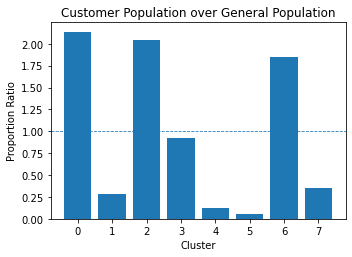

In [135]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))

ax.bar(df_clusters["Cluster"], df_clusters["ratio"])
ax.set_xlabel("Cluster")
ax.set_ylabel("Proportion Ratio")
ax.set_title("Customer Population over General Population")
ax.axhline(y=1, linestyle = "--", linewidth = 0.8)

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

#### 1.2.5. Analyze Feature Weights in Clusters with highest percentage of customers

In [136]:
def cluster_analysis(k_means, cluster, data, pca_model, metadata, n_components=2, n_weights=3):
    
    weights = k_means.cluster_centers_[cluster]
    components = list(range(len(weights)))
    
    cluster_expl = pd.DataFrame({"Weights": weights,
                                 "Component": components})
    cluster_expl.sort_values("Weights", ascending=False, inplace=True, ignore_index=True)

    comps = []
    weights = []
    comp_infos = []
    for index, row in cluster_expl.head(n=n_components).iterrows():
        
        component = int(row["Component"])
        component_info = get_feature_weights(data, pca_model, metadata, component, n_weights,
                                             verbose=True, debug=True)
        
        comp_infos.append(component_info)
        comps += [int(row["Component"])] * len(component_info)
        weights +=  [row["Weights"]] * len(component_info)
        
    component_info = pd.concat(comp_infos, ignore_index=True)
    component_info.insert(0, "Component Weight", pd.Series(weights))
    component_info.insert(0, "Component", pd.Series(comps))
        
    return component_info


In [137]:
cluster_0 = cluster_analysis(k_means, 0, univariate_azdias, pca_150, metadata_info_levels)
print_df_full(cluster_0)

UDACITY ARVATO PROJECT: 07/05/2021 01:01:50 - INFO: Start getting feature weights for component 2
UDACITY ARVATO PROJECT: 07/05/2021 01:01:50 - INFO: End getting feature weights for component 2 in 0.02513 seconds
UDACITY ARVATO PROJECT: 07/05/2021 01:01:50 - INFO: Start getting feature weights for component 3
UDACITY ARVATO PROJECT: 07/05/2021 01:01:50 - INFO: End getting feature weights for component 3 in 0.00531 seconds


,Component,Component Weight,Feature,Description,Feature Weight
0,2,5.628119,KBA13_HERST_BMW_BENZ,share of BMW & Mercedes Benz within the PLZ8,0.172609
1,2,5.628119,KBA13_SEG_SPORTWAGEN,share of sportscars within the PLZ8,0.157931
2,2,5.628119,KBA13_SEG_OBEREMITTELKLASSE,"share of upper middle class cars and upper class cars (BMW5er, BMW7er etc.)",0.150456
3,2,5.628119,KBA13_SEG_KLEINWAGEN,"share of small and very small cars (Ford Fiesta, Ford Ka etc.) in the PLZ8",-0.122615
4,2,5.628119,KBA13_KMH_140_210,share of cars with max speed between 140 and 210 km/h within the PLZ8,-0.124753
5,2,5.628119,KBA13_SITZE_5,number of cars with 5 seats in the PLZ8,-0.143796
6,3,1.849801,FINANZ_VORSORGER,financial typology: be prepared,0.143084
7,3,1.849801,ALTERSKATEGORIE_GROB,age through prename analysis,0.137480
8,3,1.849801,CJT_TYP_5,No description given,0.131650
9,3,1.849801,PRAEGENDE_JUGENDJAHRE,dominating movement in the person's youth (avantgarde or mainstream),-0.151761


In [138]:
cluster_2 = cluster_analysis(k_means, 2, univariate_azdias, pca_150, metadata_info_levels)
print_df_full(cluster_2)

UDACITY ARVATO PROJECT: 07/05/2021 01:01:50 - INFO: Start getting feature weights for component 0
UDACITY ARVATO PROJECT: 07/05/2021 01:01:50 - INFO: End getting feature weights for component 0 in 0.00386 seconds
UDACITY ARVATO PROJECT: 07/05/2021 01:01:50 - INFO: Start getting feature weights for component 6
UDACITY ARVATO PROJECT: 07/05/2021 01:01:50 - INFO: End getting feature weights for component 6 in 0.00633 seconds


,Component,Component Weight,Feature,Description,Feature Weight
0,0,3.380018,MOBI_REGIO,moving patterns,0.134626
1,0,3.380018,KBA13_ANTG1,No description given,0.126866
2,0,3.380018,LP_STATUS_FEIN,social status fine,0.126778
3,0,3.380018,KBA13_BAUMAX,No description given,-0.121810
4,0,3.380018,HH_EINKOMMEN_SCORE,estimated household_net_income,-0.122737
5,0,3.380018,KBA13_ANTG3,No description given,-0.125026
6,6,0.360526,KBA05_MAXSEG,most common car segment in the microcell,0.146497
7,6,0.360526,KBA05_MAXVORB,most common preowner structure in the microcell,0.137471
8,6,0.360526,KBA13_SEG_MITTELKLASSE,share of middle class cars (Ford Mondeo etc.) in the PLZ8,0.130846
9,6,0.360526,KBA05_KRSKLEIN,share of small cars (referred to the county average),-0.172319


In [139]:
cluster_3 = cluster_analysis(k_means, 3, univariate_azdias, pca_150, metadata_info_levels)
print_df_full(cluster_3)

UDACITY ARVATO PROJECT: 07/05/2021 01:01:50 - INFO: Start getting feature weights for component 3
UDACITY ARVATO PROJECT: 07/05/2021 01:01:50 - INFO: End getting feature weights for component 3 in 0.00597 seconds
UDACITY ARVATO PROJECT: 07/05/2021 01:01:50 - INFO: Start getting feature weights for component 8
UDACITY ARVATO PROJECT: 07/05/2021 01:01:50 - INFO: End getting feature weights for component 8 in 0.00456 seconds


,Component,Component Weight,Feature,Description,Feature Weight
0,3,2.643799,FINANZ_VORSORGER,financial typology: be prepared,0.143084
1,3,2.643799,ALTERSKATEGORIE_GROB,age through prename analysis,0.137480
2,3,2.643799,CJT_TYP_5,No description given,0.131650
3,3,2.643799,PRAEGENDE_JUGENDJAHRE,dominating movement in the person's youth (avantgarde or mainstream),-0.151761
4,3,2.643799,FINANZ_SPARER,financial typology: money saver,-0.154681
5,3,2.643799,FINANZ_ANLEGER,financial typology: investor,-0.156877
6,8,1.057370,KBA13_SEG_VAN,share of vans within the PLZ8,0.136241
7,8,1.057370,KBA13_KW_61_120,share of cars with an engine power between 61 and 120 KW - PLZ8,0.132885
8,8,1.057370,KBA05_HERST3,share of Ford/Opel,0.131122
9,8,1.057370,KBA05_MOTOR,most common engine size in the microcell,-0.116491


In [140]:
cluster_6 = cluster_analysis(k_means, 6, univariate_azdias, pca_150, metadata_info_levels)
print_df_full(cluster_6)

UDACITY ARVATO PROJECT: 07/05/2021 01:01:50 - INFO: Start getting feature weights for component 0
UDACITY ARVATO PROJECT: 07/05/2021 01:01:50 - INFO: End getting feature weights for component 0 in 0.00471 seconds
UDACITY ARVATO PROJECT: 07/05/2021 01:01:50 - INFO: Start getting feature weights for component 1
UDACITY ARVATO PROJECT: 07/05/2021 01:01:50 - INFO: End getting feature weights for component 1 in 0.00605 seconds


,Component,Component Weight,Feature,Description,Feature Weight
0,0,7.822356,MOBI_REGIO,moving patterns,0.134626
1,0,7.822356,KBA13_ANTG1,No description given,0.126866
2,0,7.822356,LP_STATUS_FEIN,social status fine,0.126778
3,0,7.822356,KBA13_BAUMAX,No description given,-0.121810
4,0,7.822356,HH_EINKOMMEN_SCORE,estimated household_net_income,-0.122737
5,0,7.822356,KBA13_ANTG3,No description given,-0.125026
6,1,3.071021,D19_GESAMT_ANZ_24,No description given,0.136826
7,1,3.071021,D19_GESAMT_ANZ_12,No description given,0.129239
8,1,3.071021,D19_VERSAND_ANZ_24,No description given,0.124030
9,1,3.071021,D19_GESAMT_DATUM,actuality of the last transaction with the complete file TOTAL,-0.126626


## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [66]:
# mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')
mailout_train = pd.read_csv(r'./datasets/mailout_train.csv', index_col='Unnamed: 0')

C:\Users\magonzac\Anaconda3\envs\pruebas\lib\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (19,20) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [67]:
mailout_train.shape

(42962, 367)

#### Check if target column is in dataset

In [68]:
TARGET_COLUMN in list(mailout_train.columns)

True

#### Check number of events / no events

0    42430
1      532
Name: RESPONSE, dtype: int64


<AxesSubplot:xlabel='RESPONSE', ylabel='count'>

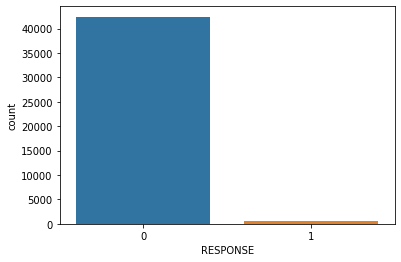

In [69]:
print(mailout_train[TARGET_COLUMN].value_counts())
sns.countplot(x=TARGET_COLUMN, data=mailout_train)

### 2.1. Selecting the evaluation metric

As we have seen in the previous step, the target is highly unbalanced. There are 42430 values 0 and only 532 values 1 (for every value 1, there are almost 80 values 0).

We must choose a metric that takes this class imbalance into account. The most common metrics for this are Precision and Recall or Area under Receiver Operating Curve (AUROC).


- Precision — Also called Positive predictive value.
    The ratio of correct positive predictions to the total predicted positives.
- Recall — Also called Sensitivity, Probability of Detection, True Positive Rate.
    The ratio of correct positive predictions to the total positives examples.
- Area under the ROC Curve — It provides an aggregate measure of performance across all possible classification thresholds.


### 2.2. Apply Preprocessing and Univariate Analysis steps

In [208]:
preprocessed_mailout = preprocessing(mailout_train, metadata_values, verbose=True, debug=False)

UDACITY ARVATO PROJECT: 11/05/2021 21:10:56 - INFO: Start Preprocessing
UDACITY ARVATO PROJECT: 11/05/2021 21:10:56 - INFO: Start getting unkown categories from metadata
UDACITY ARVATO PROJECT: 11/05/2021 21:10:56 - INFO: End getting unkown categories from metadata in 0.00275 seconds
UDACITY ARVATO PROJECT: 11/05/2021 21:10:56 - INFO: Start replacing unkown values
UDACITY ARVATO PROJECT: 11/05/2021 21:14:00 - INFO: End replacing unkown values in 184.53495 seconds
UDACITY ARVATO PROJECT: 11/05/2021 21:14:00 - INFO: End Preprocessing in 184.53672 seconds


In [211]:
univariate_mailout = univariate_analysis(preprocessed_mailout, missing_row_threshold=None, verbose=True, debug=False)

UDACITY ARVATO PROJECT: 11/05/2021 21:15:31 - INFO: Start Univariate Analysis
UDACITY ARVATO PROJECT: 11/05/2021 21:15:31 - INFO: Removing missing columns: ['KBA05_ANHANG', 'ALTER_KIND2', 'KBA05_MOD1', 'KBA05_MOD8', 'KBA05_SEG1', 'TITEL_KZ', 'KBA05_KW3', 'KK_KUNDENTYP', 'PLZ8_ANTG4', 'KBA05_SEG9', 'KBA05_SEG8', 'ALTER_KIND4', 'KBA05_SEG7', 'KBA05_SEG6', 'ALTER_KIND3', 'ALTER_HH', 'KBA05_CCM4', 'KBA05_MOTRAD', 'ALTER_KIND1', 'EXTSEL992', 'KBA05_SEG5', 'AGER_TYP', 'KBA05_BAUMAX']
UDACITY ARVATO PROJECT: 11/05/2021 21:15:31 - INFO: Start removing columns
UDACITY ARVATO PROJECT: 11/05/2021 21:15:31 - INFO: End removing columns in 0.13124 seconds
UDACITY ARVATO PROJECT: 11/05/2021 21:15:31 - INFO: Start labelling rows as missing
UDACITY ARVATO PROJECT: 11/05/2021 21:15:31 - INFO: End labelling rows as missing in 0.16222 seconds
UDACITY ARVATO PROJECT: 11/05/2021 21:15:31 - INFO: Start removing rows
UDACITY ARVATO PROJECT: 11/05/2021 21:15:32 - INFO: End removing rows in 0.2956 seconds
UDACI

### 2.3. Split data for validation and train

In [215]:
univariate_mailout = univariate_mailout.drop(ID_COLUMNS, axis=1)

In [217]:
target = univariate_mailout[TARGET_COLUMN]
features = [column for column in univariate_mailout.columns if column != TARGET_COLUMN]

In [221]:
X_train_unscaled, X_val_unscaled, y_train_unscaled, y_val_unscaled = train_test_split(univariate_mailout[features], target,
                                                                                      stratify=target, test_size=0.3,
                                                                                      random_state=RANDOM_SEED)

In [222]:
print(X_train_unscaled.shape, y_train_unscaled.shape)
print(X_val_unscaled.shape, y_val_unscaled.shape)

(30073, 342) (30073,)
(12889, 342) (12889,)


In [223]:
print(y_train_unscaled.value_counts())
print(y_val_unscaled.value_counts())

0.0    29701
1.0      372
Name: RESPONSE, dtype: int64
0.0    12729
1.0      160
Name: RESPONSE, dtype: int64


### 2.3. Set a benchmark

In [230]:
def train_and_predict(model, data_train, target_train, data_test, target_test, random_state=RANDOM_SEED,
                      verbose=False, debug=False):
    set_log_level(verbose, debug)
    timer.start()
    
    estimator_name, estimator = model
    logger.info('Start train and predict {} estimator'.format(estimator_name))
    estimator.set_params(random_state=random_state)
    
    logger.debug('Start training {} estimator'.format(estimator_name))
    estimator = estimator.fit(data_train, target_train)
    logger.debug('End training {} estimator in {} seconds'.format(estimator_name, timer.lapse()))
    
    logger.debug('Start getting evaluation metrics score')
    target_pred = estimator.predict(data_test)
    
    conf_matrix = confusion_matrix(target_test, target_pred).tolist()
    [[TP, FP], [FN, TN]] = conf_matrix
    
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    
    target_pred_proba = estimator.predict_proba(data_test)[:, 1]
    roc_score = roc_auc_score(target_test, target_pred_proba)
    
    logger.debug('End getting evaluation metrics in {}'.format(timer.lapse()))
    
    total_time = timer.total()
    logger.info('End train and predict {} estimator'.format(estimator_name, total_time))
    
    return {'AUCROC score': round(roc_score, 5),
            'confusion matrix': conf_matrix,
            'precision': precision,
            'recall': recall,
            'time': round(total_time, 3)}


In [231]:
estimator_benchmark = ['LogisticRegression', LogisticRegression()]

output_benchmark = train_and_predict(estimator_benchmark,
                                     X_train_unscaled, y_train_unscaled, X_val_unscaled, y_val_unscaled,
                                     verbose=True, debug=True)

UDACITY ARVATO PROJECT: 11/05/2021 21:28:13 - INFO: Start train and predict LogisticRegression estimator
UDACITY ARVATO PROJECT: 11/05/2021 21:28:13 - DEBUG: Start training LogisticRegression estimator
C:\Users\magonzac\Anaconda3\envs\pruebas\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
UDACITY ARVATO PROJECT: 11/05/2021 21:28:16 - DEBUG: End training LogisticRegression estimator in 3.26045 seconds
UDACITY ARVATO PROJECT: 11/05/2021 21:28:16 - DEBUG: Start getting evaluation metrics score
UDACITY ARVATO PROJECT: 11/05/2021 21:28:16 -

In [232]:
output_benchmark

{'AUCROC score': 0.66447,
 'confusion matrix': [[12729, 0], [160, 0]],
 'precision': 1.0,
 'recall': 0.987586313911087,
 'time': 3.343}

The baseline score we achieved with unscaled data with simple logistic regression is 0.65

### 2.4. Evaluate different binary classification estimators

In [233]:
models = [('LogisticRegression', LogisticRegression()),
          ('DecisionTreeClassifier', DecisionTreeClassifier()),
          ('RandomForestClassifier', RandomForestClassifier()),
          ('GradientBoostingClassifier', GradientBoostingClassifier()),
          ('AdaBoostClassifier', AdaBoostClassifier())]

#### With unscaled data

In [234]:
models_output_unscaled = {}
for estimator in models:
    models_output_unscaled[estimator[0]] = train_and_predict(estimator,
                                                             X_train_unscaled, y_train_unscaled, X_val_unscaled, y_val_unscaled,
                                                             verbose=True)
models_output_unscaled

UDACITY ARVATO PROJECT: 11/05/2021 21:28:35 - INFO: Start train and predict LogisticRegression estimator
C:\Users\magonzac\Anaconda3\envs\pruebas\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
UDACITY ARVATO PROJECT: 11/05/2021 21:28:39 - INFO: End train and predict LogisticRegression estimator
UDACITY ARVATO PROJECT: 11/05/2021 21:28:39 - INFO: Start train and predict DecisionTreeClassifier estimator
UDACITY ARVATO PROJECT: 11/05/2021 21:28:43 - INFO: End train and predict DecisionTreeClassifier estimator
UDACITY ARVATO PROJECT: 11/05

{'LogisticRegression': {'AUCROC score': 0.66447,
  'confusion matrix': [[12729, 0], [160, 0]],
  'precision': 1.0,
  'recall': 0.987586313911087,
  'time': 3.38},
 'DecisionTreeClassifier': {'AUCROC score': 0.53549,
  'confusion matrix': [[12528, 201], [149, 11]],
  'precision': 0.9842092858826302,
  'recall': 0.988246430543504,
  'time': 4.095},
 'RandomForestClassifier': {'AUCROC score': 0.58417,
  'confusion matrix': [[12729, 0], [160, 0]],
  'precision': 1.0,
  'recall': 0.987586313911087,
  'time': 16.638},
 'GradientBoostingClassifier': {'AUCROC score': 0.74752,
  'confusion matrix': [[12727, 2], [160, 0]],
  'precision': 0.9998428784664938,
  'recall': 0.9875843873671142,
  'time': 86.829},
 'AdaBoostClassifier': {'AUCROC score': 0.73132,
  'confusion matrix': [[12729, 0], [160, 0]],
  'precision': 1.0,
  'recall': 0.987586313911087,
  'time': 26.407}}

#### Balancing classes weights

In [239]:
balanced_models = [('LogisticRegression', LogisticRegression(class_weight='balanced')),
                   ('DecisionTreeClassifier', DecisionTreeClassifier(class_weight='balanced')),
                   ('RandomForestClassifier', RandomForestClassifier(class_weight='balanced'))]

In [240]:
balanced_models_output_unscaled = {}
for estimator in balanced_models:
    balanced_models_output_unscaled[estimator[0]] = train_and_predict(estimator,
                                                                      X_train_unscaled, y_train_unscaled, X_val_unscaled, y_val_unscaled,
                                                                      verbose=True)
balanced_models_output_unscaled

UDACITY ARVATO PROJECT: 11/05/2021 21:40:52 - INFO: Start train and predict LogisticRegression estimator
C:\Users\magonzac\Anaconda3\envs\pruebas\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
UDACITY ARVATO PROJECT: 11/05/2021 21:40:55 - INFO: End train and predict LogisticRegression estimator
UDACITY ARVATO PROJECT: 11/05/2021 21:40:55 - INFO: Start train and predict DecisionTreeClassifier estimator
UDACITY ARVATO PROJECT: 11/05/2021 21:40:59 - INFO: End train and predict DecisionTreeClassifier estimator
UDACITY ARVATO PROJECT: 11/05

{'LogisticRegression': {'AUCROC score': 0.66747,
  'confusion matrix': [[8517, 4212], [71, 89]],
  'precision': 0.6691020504360122,
  'recall': 0.9917326502095948,
  'time': 2.983},
 'DecisionTreeClassifier': {'AUCROC score': 0.51686,
  'confusion matrix': [[12067, 662], [146, 14]],
  'precision': 0.9479927724094587,
  'recall': 0.9880455252599689,
  'time': 3.753},
 'RandomForestClassifier': {'AUCROC score': 0.60665,
  'confusion matrix': [[12433, 296], [153, 7]],
  'precision': 0.9767460130410873,
  'recall': 0.9878436357857937,
  'time': 16.275}}

#### Scaling data

Try with different binary classification estimators with scaled data

In [241]:
scaler = StandardScaler()
scaler.fit(univariate_mailout)

univariate_mailout_scaled = feature_scaling(univariate_mailout, scaler, verbose=True, debug=True)

UDACITY ARVATO PROJECT: 11/05/2021 21:45:08 - INFO: Start Feature Scaling
UDACITY ARVATO PROJECT: 11/05/2021 21:45:08 - INFO: End Feature Scaling in 0.17493 seconds


In [244]:
X_train, X_val, y_train, y_val = train_test_split(univariate_mailout_scaled[features], target,
                                                  stratify=target, test_size=0.3,
                                                  random_state=RANDOM_SEED)

In [245]:
models_output = {}
for estimator in models:
    models_output[estimator[0]] = train_and_predict(estimator,
                                                    X_train, y_train, X_val, y_val,
                                                    verbose=True)
models_output

UDACITY ARVATO PROJECT: 11/05/2021 21:49:24 - INFO: Start train and predict LogisticRegression estimator
C:\Users\magonzac\Anaconda3\envs\pruebas\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
UDACITY ARVATO PROJECT: 11/05/2021 21:49:26 - INFO: End train and predict LogisticRegression estimator
UDACITY ARVATO PROJECT: 11/05/2021 21:49:26 - INFO: Start train and predict DecisionTreeClassifier estimator
UDACITY ARVATO PROJECT: 11/05/2021 21:49:31 - INFO: End train and predict DecisionTreeClassifier estimator
UDACITY ARVATO PROJECT: 11/05

{'LogisticRegression': {'AUCROC score': 0.64353,
  'confusion matrix': [[12729, 0], [160, 0]],
  'precision': 1.0,
  'recall': 0.987586313911087,
  'time': 2.847},
 'DecisionTreeClassifier': {'AUCROC score': 0.5354,
  'confusion matrix': [[12526, 203], [149, 11]],
  'precision': 0.984052164349124,
  'recall': 0.9882445759368836,
  'time': 4.133},
 'RandomForestClassifier': {'AUCROC score': 0.5846,
  'confusion matrix': [[12729, 0], [160, 0]],
  'precision': 1.0,
  'recall': 0.987586313911087,
  'time': 16.647},
 'GradientBoostingClassifier': {'AUCROC score': 0.74752,
  'confusion matrix': [[12727, 2], [160, 0]],
  'precision': 0.9998428784664938,
  'recall': 0.9875843873671142,
  'time': 88.689},
 'AdaBoostClassifier': {'AUCROC score': 0.73132,
  'confusion matrix': [[12729, 0], [160, 0]],
  'precision': 1.0,
  'recall': 0.987586313911087,
  'time': 25.694}}

#### Balancing classes weights

In [251]:
balanced_models_output = {}
for estimator in balanced_models:
    balanced_models_output[estimator[0]] = train_and_predict(estimator,
                                                             X_train, y_train, X_val, y_val,
                                                             verbose=True)
balanced_models_output

UDACITY ARVATO PROJECT: 11/05/2021 21:55:58 - INFO: Start train and predict LogisticRegression estimator
C:\Users\magonzac\Anaconda3\envs\pruebas\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
UDACITY ARVATO PROJECT: 11/05/2021 21:56:02 - INFO: End train and predict LogisticRegression estimator
UDACITY ARVATO PROJECT: 11/05/2021 21:56:02 - INFO: Start train and predict DecisionTreeClassifier estimator
UDACITY ARVATO PROJECT: 11/05/2021 21:56:06 - INFO: End train and predict DecisionTreeClassifier estimator
UDACITY ARVATO PROJECT: 11/05

{'LogisticRegression': {'AUCROC score': 0.65002,
  'confusion matrix': [[9234, 3495], [87, 73]],
  'precision': 0.7254301201979731,
  'recall': 0.9906662375281622,
  'time': 3.051},
 'DecisionTreeClassifier': {'AUCROC score': 0.51691,
  'confusion matrix': [[12068, 661], [146, 14]],
  'precision': 0.9480713331762118,
  'recall': 0.9880465040117897,
  'time': 3.975},
 'RandomForestClassifier': {'AUCROC score': 0.60759,
  'confusion matrix': [[12433, 296], [153, 7]],
  'precision': 0.9767460130410873,
  'recall': 0.9878436357857937,
  'time': 16.364}}

### 2.5. Select the best binary classification estimator

#### 2.5.1. Give the best results after hyperparameter tunning

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter.

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.